In [2]:
import os
import glob

# Visualisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msn
from LightGBM_with_simple_features_modified import *
from functions_proj_7 import *

### CONTEXTE

L'entreprise <b>Prêt à dépenser</b> souhaite mettre en œuvre un outil de 'scoring crédit' pour calculer la probabilité qu'un client rembourse son crédit. En fonction, la demande de crédit est classifiée comme <b>accordée</b> ou <b>refusée</b>. Cette entreprise souhaite développer un algorithme de classification en s'appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d'octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l'entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 




### PROBLEMATIQUE

Il s'agit d'un problème de classification avec deux classes déséquilibrées. La notion de solvabilité d'un client sera définie selon un seuil de classification.

Pour un organisme de crédit, il est important de minimiser le taux de faux négatifs afin d'éviter des pertes financières engendrées par l'insolvabilité d'un client.

Les faux positifs ne sont pas importants. Un client qui se voit refuser un crédit alors qu'il est solvable sera considéré comme un manque à gagner mais pas une perte directe.

'''Afin d'intégrer ces contraintes, l'évaluation des différentes modélisations sera basée sur les métriques ROC_AUC et la fonction de coût métier F_beta score.

Une courbe ROC <u>Receiver Operator Characteristic</u> est un graphique utilisé pour montrer la capacité de prédiction d'un classifieur binaire.

Cette dernière est construite en traçant le taux de vrais positifs (TPR ou <u>Recall</u>) en fonction du taux de faux positifs (FPR). La mesure ROC_AUC est l'aire sous la courbe ROC, elle est comprise entre 0 et 1. 
- Pour un modèle de classification dont les prédictions sont 100 % fausses, ROC_AUC = 0. 
- Pour un modèle dont les prédictions sont 100 % correctes, ROC_AUC = 1.

La mesure ROC_AUC évalue la qualité des prédictions du modèle quel que soit le seuil de classification choisi. Or, la problématique traitée intègre deux contraintes. La première contrainte, technique, concerne le seuil de classication afin de déterminer la solvabilité d'un client. La seconde contrainte, métier, nécessite la minimisation des faux positifs afin de limiter les pertes finacières. C'est pourquoi, la mesure ROC_AUC sera completée par la fonction coût $F_\beta score$ dans l'évaluation des modèles.

Nous traiterons de la fonction $F_\beta score$ plus tardivement.

Note :
- Le taux positif réel est la proportion d’observations qui ont été correctement prédites positives parmi toutes les observations positives
- le taux de faux positifs est la proportion d’observations qui sont incorrectement prédites positives parmi toutes les observations négatives.


### Mission
1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d'améliorer la connaissance client des chargés de relation client.


### Spécifications du dashboard

- Permettre de visualiser le score et l'interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l'ensemble des clients ou à un groupe de clients similaires.

## 1. <b>Chargement des données</b>

In [3]:
print("Liste des fichiers :")
display(os.listdir('./home-credit-default-risk/data/'))
display(os.listdir('./home-credit-default-risk/description/'))

Liste des fichiers :


['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

['HomeCredit_columns_description.csv']

Le jeu de donnée compte 9 fichiers : 
   - Un fichier principal d'entrainement (avec la cible)
   - Un fichier principal de test (sans la cible)
   - Un fichier de description
   - 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.
    
Ci-dessous le détail de chacun des fichiers :
   - <b>application_{train|test}.csv</b> : Ce sont les données principales d'entrainement et de test. Ces fichiers contiennent les informations sur chaque demande de prêt chez HomeCredit. Les données d'entraînement sont accompagnées de la variable TARGET valorisée à 0 si le prêt a été remboursé ou à 1 en cas contraire.
    Une ligne/un prêt (identifié par la variable SK_ID).
   - <b>bureau.csv</b> : Il s'agit de l'historique de crédit de tous les clients auprès d'autres institutions financières (avant la demande de prêt). 
    Une ligne/un crédit. Néanmoins une demande de prêt peut être associée à plusieurs crédits.
   - <b>bureau_balance.csv</b> : Soldes mensuels des crédits antérieurs. Une ligne par mois par crédit.
   - <b>POS_CASH_balance.csv</b> : Un aperçu des données mensuelles de prêts auprès de points de vente ou comptant. Une ligne correspond à un mois de prêt.
    Un prêt peut avoir plusieurs lignes.
   - <b>credit_card_balance.csv</b> : Données mensuelles des cartes de crédits des clients. Un ligne par mois, par carte de crédit.
    Une carte de crédit peut avoir plusieurs lignes.
   - <b>previous_application.csv</b> : Tous les demandes de crédits antérieures des clients. Une ligne par demande. Chaque demande est identifiée par la variable SK_ID_PREV.
   - <b>installments_payments.csv</b> : Historique de paiement. Une ligne par paiement effectué, une ligne par paiement manqué. Un paiement correspond à un échelon/mensualité.
   - <b>HomeCredit_columns_description.csv</b> : Contient la description des colonnes de tous les fichiers précédents. 
    
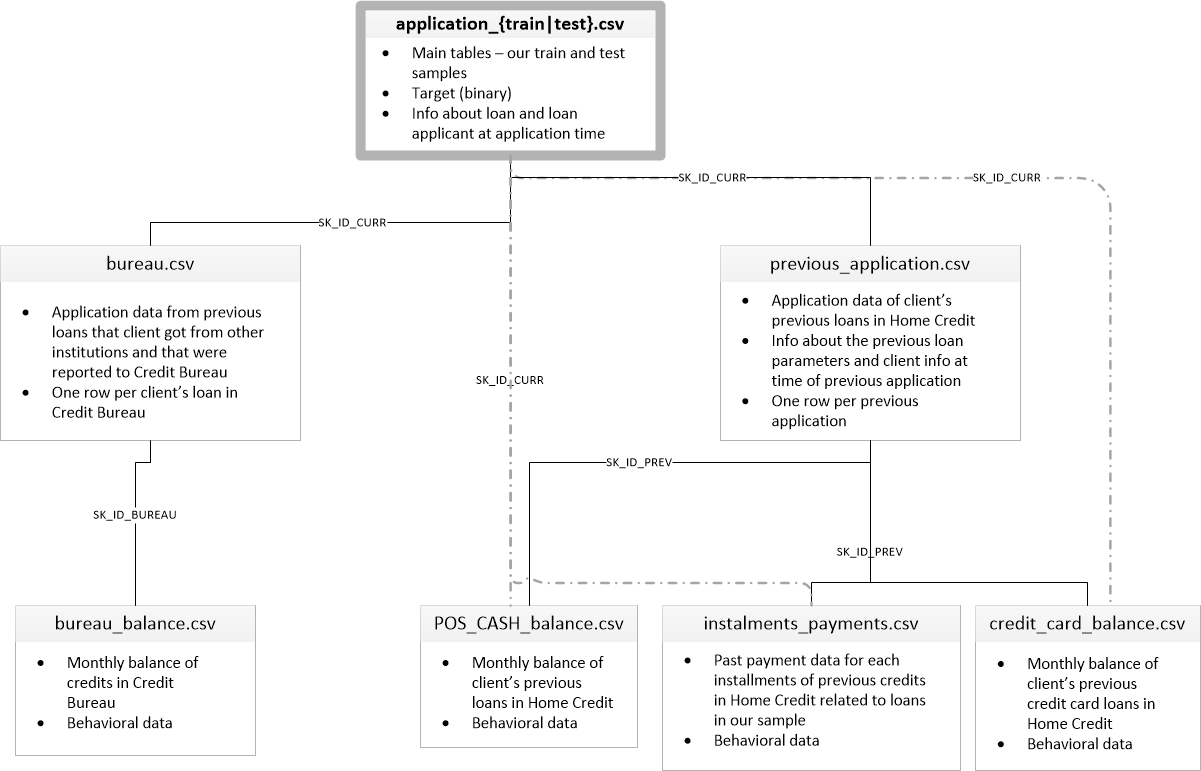

In [4]:
%%time 
# Récupération des fichiers
application_train = pd.read_csv('home-credit-default-risk/data/application_train.csv')
application_test = pd.read_csv('home-credit-default-risk/data/application_test.csv')
bureau = pd.read_csv('home-credit-default-risk/data/bureau.csv')
bureau_balance = pd.read_csv('home-credit-default-risk/data/bureau_balance.csv')
credit_card_balance = pd.read_csv('home-credit-default-risk/data/credit_card_balance.csv')
installments_payments = pd.read_csv('home-credit-default-risk/data/installments_payments.csv')
POS_CASH_balance = pd.read_csv('home-credit-default-risk/data/POS_CASH_balance.csv')
previous_application = pd.read_csv('home-credit-default-risk/data/previous_application.csv')
column_description = pd.read_csv('home-credit-default-risk/description/HomeCredit_columns_description.csv',  encoding="ISO-8859-1", index_col=[0])

Wall time: 31.8 s


In [5]:
print("Documentation :")
column_description.head(10)

Documentation :


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [6]:
# Describe des fichiers d'entrée
file_describe(folder = glob.glob('./home-credit-default-risk/data/*.csv'))

,Rows,Columns,Missing Values (%),Duplicate (%),object_dtype,float_dtype,int_dtype,bool_dtype
application_test.csv,48744,121,23.81,0.0,16,65,40,0
application_train.csv,307511,122,24.40,0.0,16,65,41,0
bureau.csv,1716428,17,13.50,0.0,3,8,6,0
bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0
credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0
installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0
POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0
previous_application.csv,1670214,37,17.98,0.0,16,15,6,0
sample_submission.csv,48744,2,0.00,0.0,0,1,1,0


#### Demande de prêts  <i>Application_train</i>

In [7]:
print("Format données d'entrainement :",  application_train.shape)
print("Format données de test :",  application_test.shape)

Format données d'entrainement : (307511, 122)
Format données de test : (48744, 121)


Les deux fichiers ne présentent pas le même nombre de variables.

In [8]:
print("Vérification de la différence de variables entre les deux fichiers...")
set_test = set(application_test.columns)
set_train = set(application_train.columns)
print("Ci-dessous les colonnes non partagées par les fichiers:", set_train.symmetric_difference(set_test))

Vérification de la différence de variables entre les deux fichiers...
Ci-dessous les colonnes non partagées par les fichiers: {'TARGET'}


Seule la cible n'est pas partagée par les deux fichiers.
Le fichier de test ne nous servira donc pas pour ce projet.

## 2. Analyse Exploratoire

### 1. Répartition de la cible

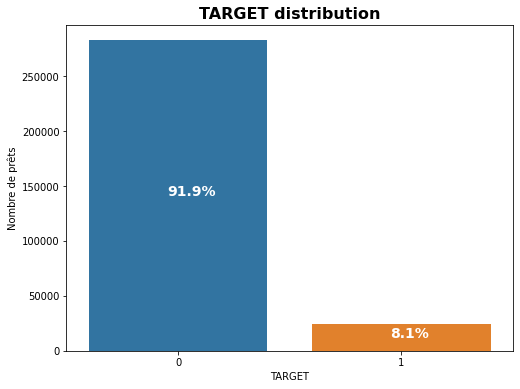

In [9]:
plot_target(application_train, 'TARGET', 'TARGET distribution', 'Nombre de prêts')

Les classes sont déséquilibrées. La très grande majorité des prêts a été remboursée à temps.

### 2. Répartition des clients par genre 

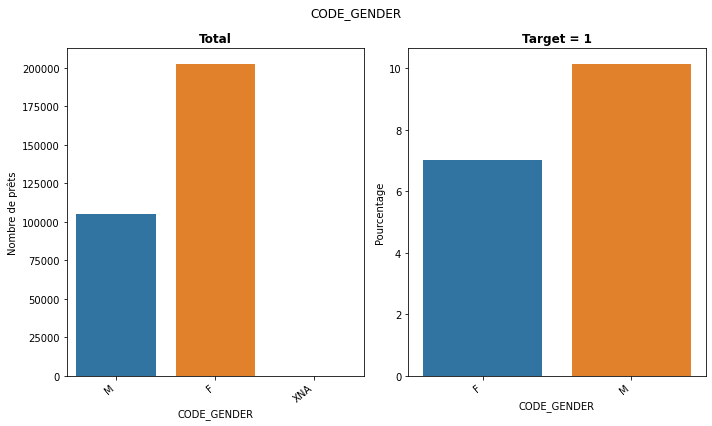

In [10]:
plot_disc_var_global_and_target_1(application_train, 'CODE_GENDER')

Les clients sont majoritairement des femmes. Les hommes semblent faire davantage d'impayés (en proportion).
A noter que les clients de genre XNA, ont remboursé l'intégralité de leur prêt.

### 3. Répartition des clients selon leur situation familiale

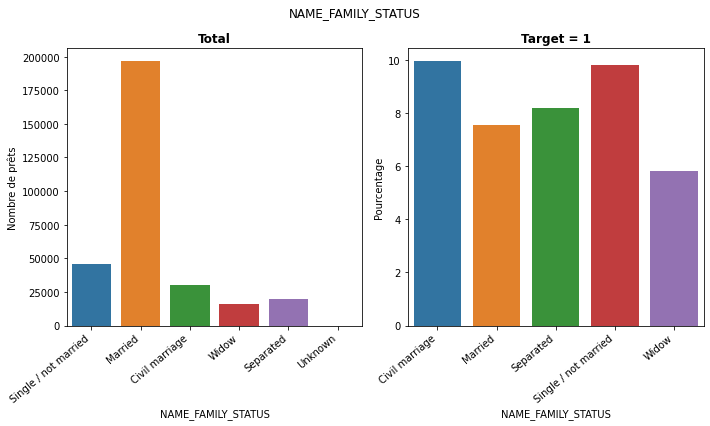

In [11]:
plot_disc_var_global_and_target_1(application_train, 'NAME_FAMILY_STATUS')

Les clients mariés représentent la majorité du jeu de donnée.
Les clients mariés civilement et les clients célibataires sont ceux qui semblent avoir le plus de chances d'être en défaut de paiement.
Les veuves/veufs semblent obtenir les meilleurs scores.

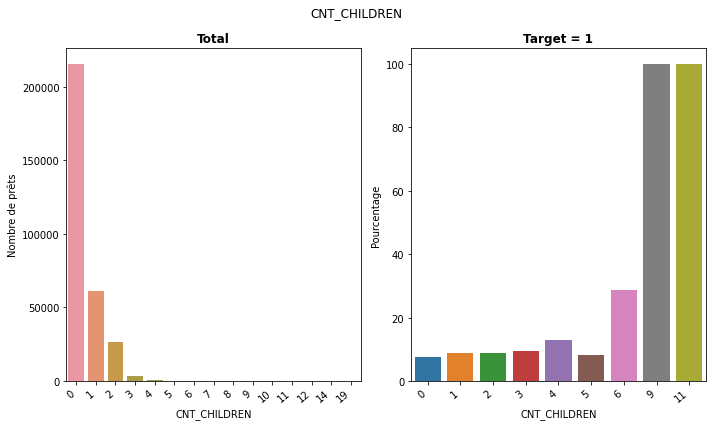

In [12]:
plot_disc_var_global_and_target_1(application_train, 'CNT_CHILDREN')

La très grande majorité des clients n'a pas d'enfant.
La probabilité d'être en défaut de paiement semble augmenter avec le nombre d'enfant dans le foyer.

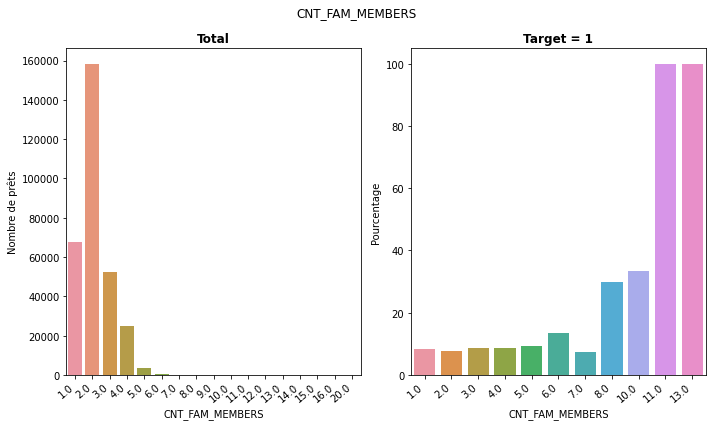

In [13]:
plot_disc_var_global_and_target_1(application_train, 'CNT_FAM_MEMBERS')

Comme nous l'avons vu précédemment, il y a davantage de couples mariés que de clients célibataires. Ceci explique le pic de foyer à deux personnes.
L'évolution semble être similaire au nombre d'enfants par foyer. Plus le foyer compte de membres, plus la possibilité d'être en défaut de paiement est grande.

### 4. Répartition des clients selon leur âge

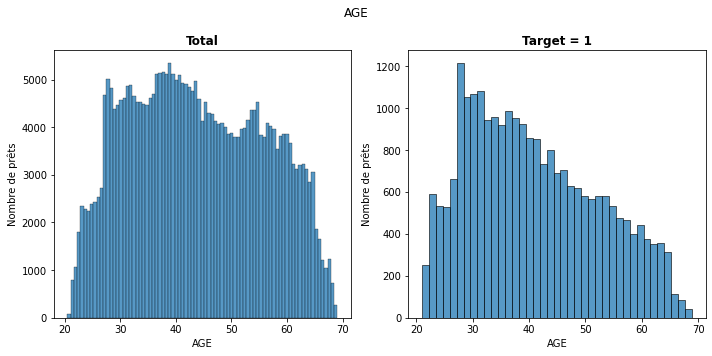

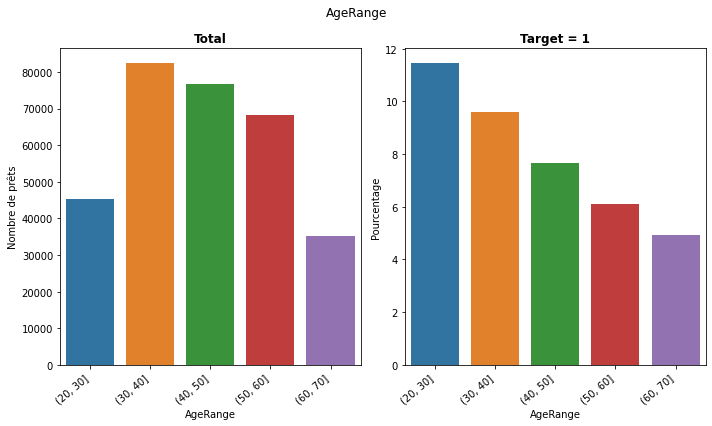

In [14]:
application_train['AGE'] = application_train['DAYS_BIRTH'].abs() / 365.25
application_train['AgeRange'] = pd.cut(x=application_train['AGE'], bins=[20,30,40,50,60,70])

hist_cont_var_global_and_target_1(application_train, 'AGE', log=False)
plot_disc_var_global_and_target_1(application_train, 'AgeRange')

del application_train['AGE']
del application_train['AgeRange']

L'âge des clients varie entre <b>20</b> et <b>70 ans</b>. 
Il est intéressant de noter que les personnes jeunes (> 40 ans) sont plus enclines à ne pas rembourser leur prêt.
C'est dautant plus intéressant pour les personnes ayant moins de 30 ans car elles sont peu présentes dans le jeu de données.

### 5. Répartition des clients selon les revenus

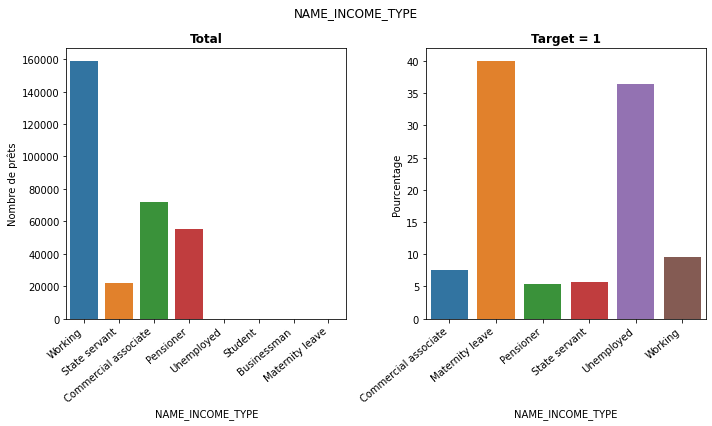

In [15]:
# Type de revenus
plot_disc_var_global_and_target_1(application_train, 'NAME_INCOME_TYPE')

La source de revenus majoritaire provient <b>d'activités professionnelles</b>.
Les <b>congés maternités</b> et les <b>chômeurs</b> sont peu représentés mais ce sont les status qui présentent <b>le plus de défaut de paiement</b>.

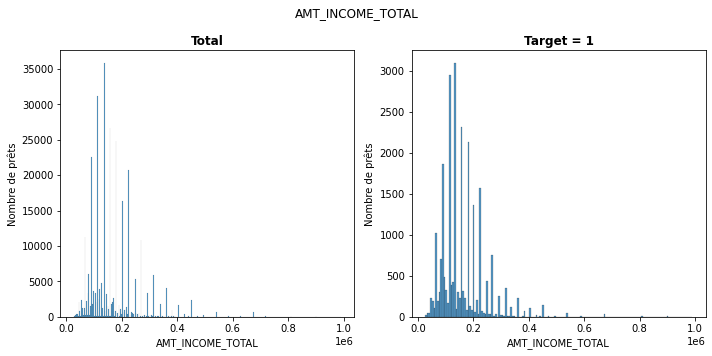

In [16]:
# Montant des revenus
hist_cont_var_global_and_target_1(application_train[application_train.AMT_INCOME_TOTAL < 1000000], 'AMT_INCOME_TOTAL', log=False)

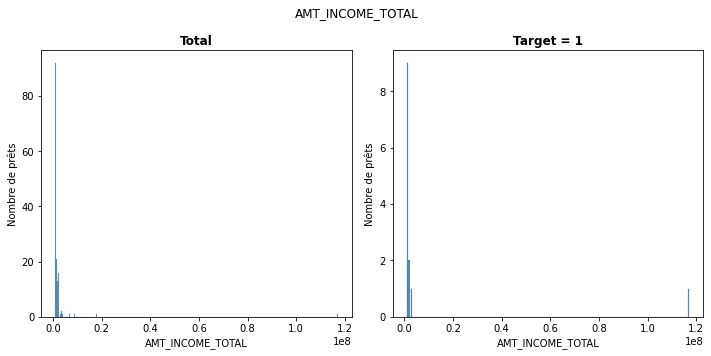

In [17]:
hist_cont_var_global_and_target_1(application_train[application_train.AMT_INCOME_TOTAL >= 1000000], 'AMT_INCOME_TOTAL', log=False)

Visiblement, le montant des revenus ne semble pas impacter le défaut de paiement d'un client.
Des prêts sont refusés pour des petits revenus mais également pour de hauts revenus.
La distribution des revenus des personnes en défaut de paiement est très similaire à la distribution des revenus globale.

A noter qu'un très faible pourcentage de clients ont des revenus > 1 millions (250 sur 300 000).

### 6. Répartition des clients selon leur emploi

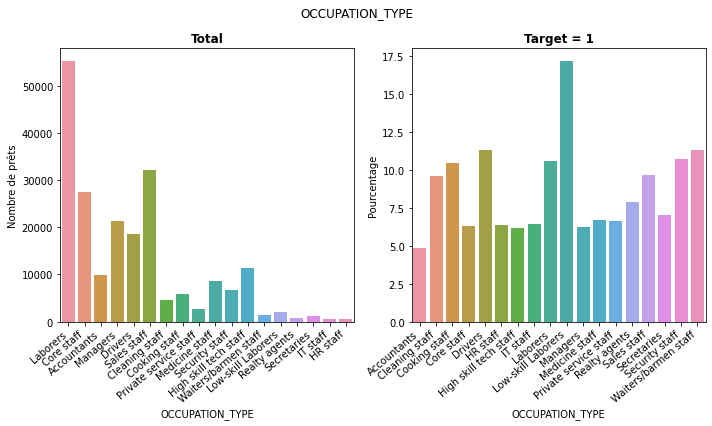

In [18]:
# Profession des clients
plot_disc_var_global_and_target_1(application_train, 'OCCUPATION_TYPE')

Les professions qui compte le plus de demande de prêts sont les <b>professions ouvrières</b>.
Les professions qui présentent le plus de défaut de paiement sont les professions ouvrières peu qualifiées, suivi des chauffeurs, barmans, serveurs... Il s'agit de professions qui demandent peu de qualifications.

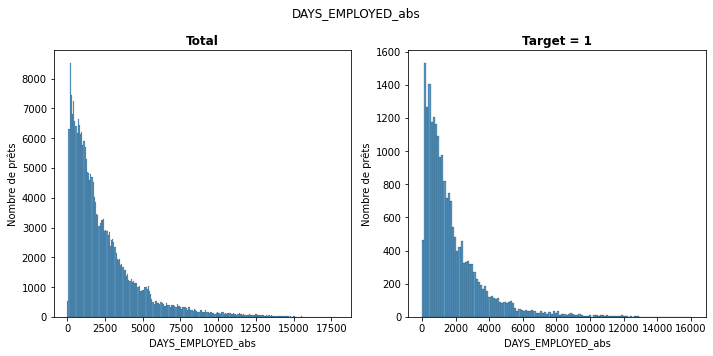

In [19]:
# Durée d'emploi à date de la demande
application_train['DAYS_EMPLOYED_abs'] = application_train['DAYS_EMPLOYED'].abs()

hist_cont_var_global_and_target_1(application_train[application_train.DAYS_EMPLOYED < 365243], 'DAYS_EMPLOYED_abs', log=False)

del application_train['DAYS_EMPLOYED_abs']

La distribution de la variable semble la même globalement et pour les clients en défaut de paiement.
Dans les deux cas, nous retrouvons des clients sans emploi ou en poste depuis peu, ou depuis longtemps.

### 7. Répartition des clients selon leur niveau d'études

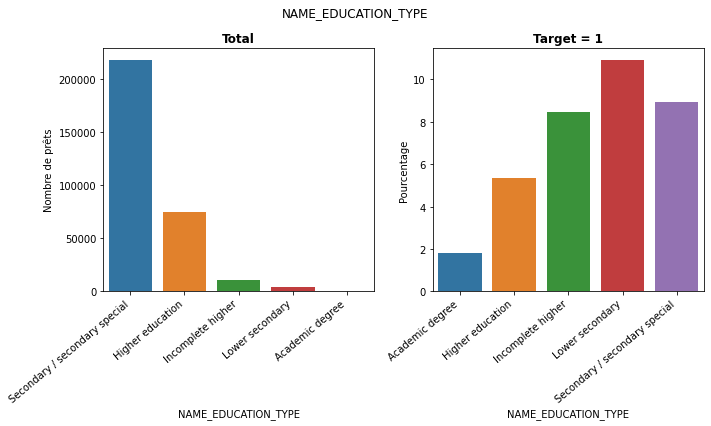

In [20]:
plot_disc_var_global_and_target_1(application_train, 'NAME_EDUCATION_TYPE')

La majorité des clients a un niveau d'étude <b>secondaire</b>.
Les clients ayant une éducation secondaire inférieure sont ceux qui présentent le plus d'impayés.

### 8. Les crédits

Type de crédit, usage, les montants, la durée de remboursement....

#### Type de crédit

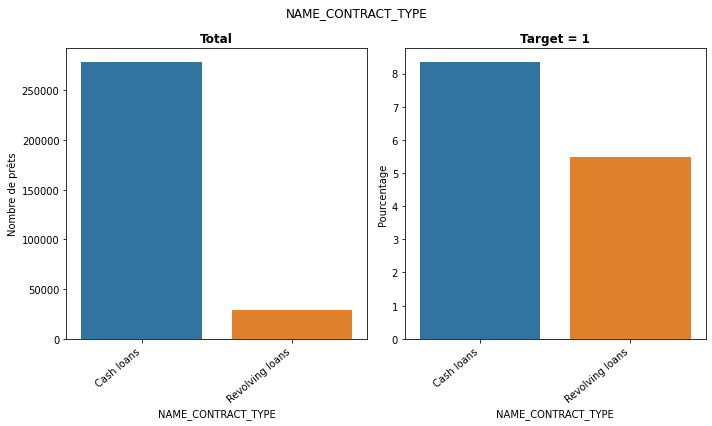

In [21]:
plot_disc_var_global_and_target_1(application_train, 'NAME_CONTRACT_TYPE')

Les crédits amortissables dominent le jeu de donnée. Ils ont également plus de chance de ne pas être honorés contrairement au crédit renouvelable.

#### Montant demandé

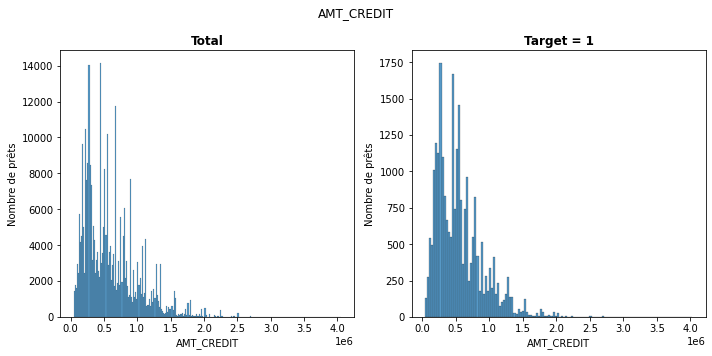

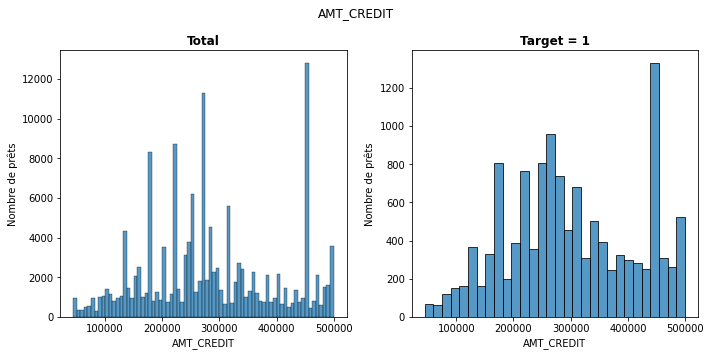

In [22]:
hist_cont_var_global_and_target_1(application_train, 'AMT_CREDIT', log=False)
hist_cont_var_global_and_target_1(application_train[application_train.AMT_CREDIT < 500000], 'AMT_CREDIT', log=False)

Comme beaucoup de distribution de variable numérique jusqu'ici, la répartition chez les personnes en défaut de paiement est assez similaire à la population générale.

#### Usage

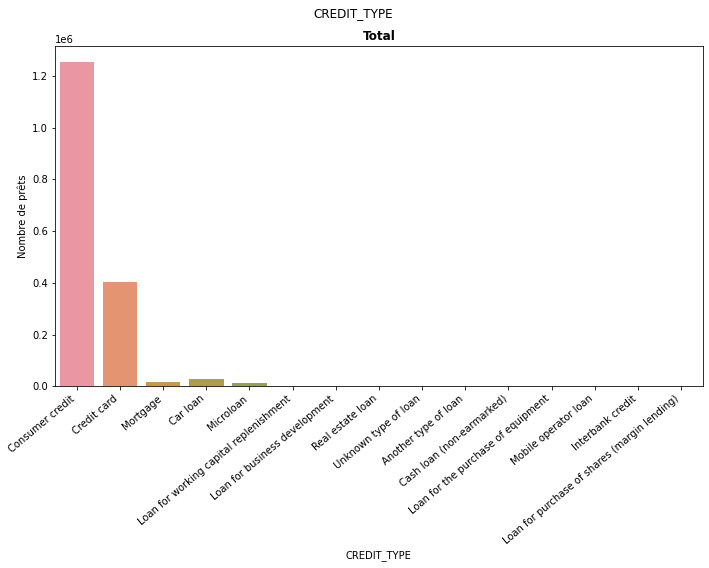

In [23]:
plot_disc_var_global(bureau, 'CREDIT_TYPE')

Les crédit demandés sont essentiellement des crédits à la consommations.

### 3. Feature Engineering

Cette partie sera consacrée aux opérations de feature engineering.

- Création de nouvelles variables (aggrégation)
- Traitement des variables manquantes
- Suppression de variables avec forte colinéarité


In [24]:
# Utilisation du kenerl : LightGBM with Simple Features - https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
my_data = main()

Train samples: 307511
Bureau df shape: (305811, 119)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 28s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 31s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 22s


In [25]:
print("le fichier présente désormais", my_data.shape[0], "lignes et", my_data.shape[1], 'colonnes.' )

le fichier présente désormais 307507 lignes et 801 colonnes.


In [26]:
# Détail du fichier
dataframe_describe(data = my_data)

,Rows,Columns,Missing Values (%),Duplicate (%),object_dtype,float_dtype,int_dtype,bool_dtype
data,307507,801,25.88,0.0,0,624,44,0


Un quart des valeurs sont absentes.

In [27]:
# Suppression des variables dont le remplissage n'atteint pas les 60 %.
my_data_red = my_data.dropna(how='any',axis=1,thresh=my_data.shape[0]*0.6)

In [28]:
dataframe_describe(data = my_data_red)

,Rows,Columns,Missing Values (%),Duplicate (%),object_dtype,float_dtype,int_dtype,bool_dtype
data,307507,556,6.44,0.0,0,379,44,0


In [29]:
print("Nombre de variables à présent :", my_data_red.shape[1])

Nombre de variables à présent : 556


In [30]:
missing_values_by_col = get_percentage_missing_by_col(my_data_red).reset_index()

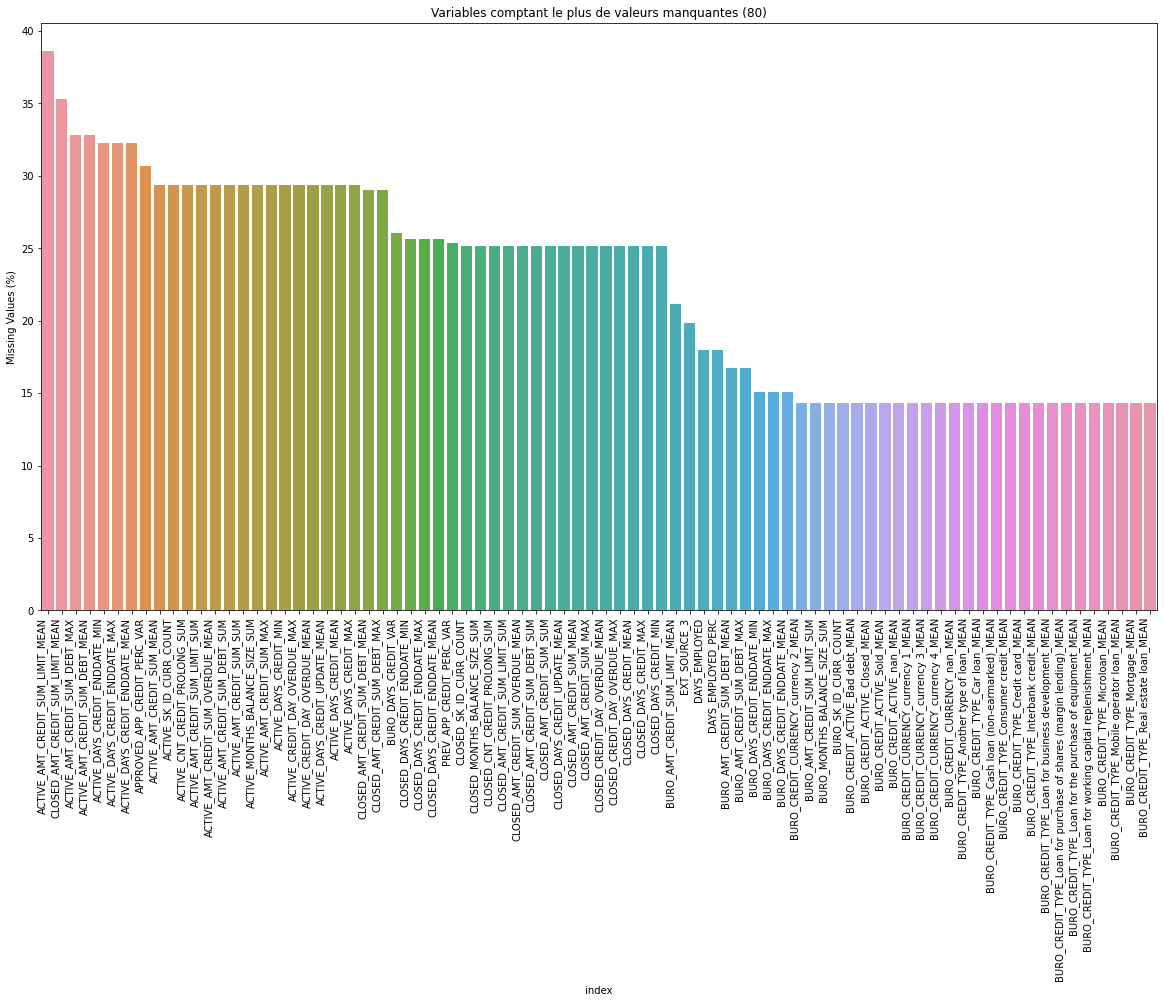

In [31]:
fig, ax = plt.subplots(figsize=(20,12)) 
sns.barplot(y='Missing Values (%)', x='index', data=missing_values_by_col[missing_values_by_col['Missing Values (%)'] > 0][:80])
plt.title('Variables comptant le plus de valeurs manquantes (80)')
fig.autofmt_xdate(rotation=90)

In [32]:
print("Les différents types de variables du dataframe:", missing_values_by_col.data_type.unique())

Les différents types de variables du dataframe: [dtype('float64') dtype('int64') dtype('uint8')]


Toutes les données sont numériques.

In [33]:
# Taux de remplissage par ligne
missing_values_by_row = get_percentage_missing_by_row(my_data_red).reset_index()

In [34]:
missing_values_by_row.head(2)

,index,Missing Values (%)
0,10249,65.83
1,215458,65.83


Certaines lignes sont très peu remplies. Elles comptent 65 % de valeurs manquantes.

In [35]:
row_mis_val_sup_50 = missing_values_by_row[missing_values_by_row['Missing Values (%)'] >= 50]['index']
print("Nombre de lignes ayant un taux de valeurs manquantes supérieur ou égal à 50 %:", len(row_mis_val_sup_50))

Nombre de lignes ayant un taux de valeurs manquantes supérieur ou égal à 50 %: 7340


In [36]:
my_data_red.drop(index=row_mis_val_sup_50, inplace=True)

C:\Users\aurel\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [37]:
print("Nombre de lignes à présent :", my_data_red.shape[0])

Nombre de lignes à présent : 300167


In [38]:
cols_missing_values_false = missing_values_by_col[missing_values_by_col['Missing Values (%)'] == 0].index
print("Nombre de colonnes sans valeurs manquantes:", len(cols_missing_values_false))
print("Nombre de colonnes présentant des valeurs manquantes:", my_data_red.shape[1] - len(cols_missing_values_false))

Nombre de colonnes sans valeurs manquantes: 188
Nombre de colonnes présentant des valeurs manquantes: 368


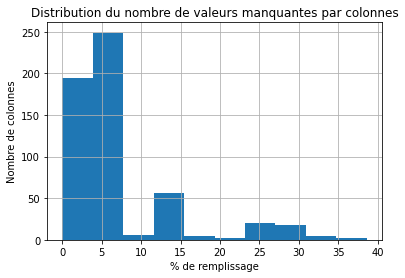

In [39]:
missing_values_by_col.hist();
plt.xlabel('% de remplissage');
plt.ylabel('Nombre de colonnes');
plt.title('Distribution du nombre de valeurs manquantes par colonnes');

L'essentiel des variables semblent avoir moins de 10 % de valeurs manquantes.

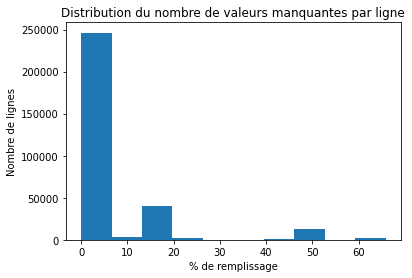

In [40]:
plt.hist(missing_values_by_row['Missing Values (%)']);
plt.xlabel('% de remplissage');
plt.ylabel('Nombre de lignes');
plt.title('Distribution du nombre de valeurs manquantes par ligne');

Il en est de même pour les lignes. L'essentiel est en dessous de 10 %.

#### Traitement des données manquantes (np.inf)

In [41]:
# Lignes où apparaissent les données inf
index_list = my_data_red.index[np.isinf(my_data_red).any(1)]
print('Nombre de lignes avec valeur inf:', len(index_list))

Nombre de lignes avec valeur inf: 19


In [42]:
# Variables/Colonnes où apparaissent les données inf
var_inf = my_data_red.columns.to_series()[np.isinf(my_data_red).any()].unique()
print('Variables concernées par la valeur inf:', var_inf)

Variables concernées par la valeur inf: ['PREV_APP_CREDIT_PERC_MAX' 'INSTAL_PAYMENT_PERC_MAX']


In [43]:
my_data_red[['PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']].describe()

,PREV_APP_CREDIT_PERC_MAX,INSTAL_PAYMENT_PERC_MAX
count,2.908260e+05,2.914020e+05
mean,inf,inf
std,NaN,NaN
min,0.000000e+00,5.121918e-01
25%,1.000000e+00,1.000000e+00
50%,1.042587e+00,1.000000e+00
75%,1.131821e+00,1.000000e+00
max,inf,inf


Nous allons remplacer les données INF par 1.

In [44]:
# Remplacement des données inf par 1. Les mensualités sont payées. (Il s'agit de division par 0)
my_data_red=my_data_red.replace(np.inf, 1)

#### Traitement des données manquantes (valeur NaN)
Nous allons finalement supprimer toutes les lignes ayant une valeur NaN.
Si le dataframe résultat présente la même distribution de données, nous l'utiliserons en tant que données d'entrainement.

In [49]:
index_with_nan = my_data_red.index[my_data_red.isnull().any(axis=1)]
print('Nombre de lignes ayant une valeur NaN :', len(index_with_nan))

Nombre de lignes ayant une valeur NaN : 221107


In [50]:
my_data_red_ss_NaN = my_data_red.drop(index=index_with_nan)

In [51]:
my_data_w = my_data_red_ss_NaN.copy()

#### Trouver les variables avec une forte colinearité avec la cible 
Nous allons privilégier les variables fortement correlées avec la cible....

In [52]:
#Methode pearson, kendall, spearman (par défaut : pearson)
corr_df = my_data_w.corr()

In [53]:
corr_df['TARGET'].sort_values(ascending=False)[:10]

TARGET                                    1.000000
BURO_DAYS_CREDIT_MEAN                     0.101859
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.086872
BURO_DAYS_CREDIT_MIN                      0.076301
CLOSED_DAYS_CREDIT_MEAN                   0.075351
CLOSED_DAYS_CREDIT_MIN                    0.074780
BURO_CREDIT_ACTIVE_Active_MEAN            0.074565
BURO_DAYS_CREDIT_UPDATE_MEAN              0.072885
ACTIVE_SK_ID_CURR_COUNT                   0.070296
DAYS_EMPLOYED                             0.069069
Name: TARGET, dtype: float64

Il ne semble pas y avoir de variables avec une très forte correlation avec la cible.

## 2. Sélection du meilleur modèle de classification.

Nous allons sélectionner le meilleur modèle de classification parmi les modèles suivants :
- Random Forest Classifier
- Gradient boosting Classifier
- Light Gradient boosting Classifier
- Regression logistic (servira de baseline)

Chacun de ses modèles sera testé selon les 3 méthodes de rééquilibrage des données.

- Pondération : On affecte à chacune des classes un poids différent.

- Undersampling ou sous-échantillonnage : Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires. Cette approche permet de diminuer la redondance des informations apportées par le grand nombre d’individus majoritaires.

- Oversampling ou sur-échantillonnage : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation. Différentes solutions sont possibles, comme le “clonage” aléatoire, SMOTE ou encore ADASYN.

Les tests se feront sur le jeu de données nettoyés : my_data_w

In [54]:
# Changement de l'index du fichier
my_data_w.set_index('SK_ID_CURR', inplace=True)
my_data_w.shape

(79060, 555)

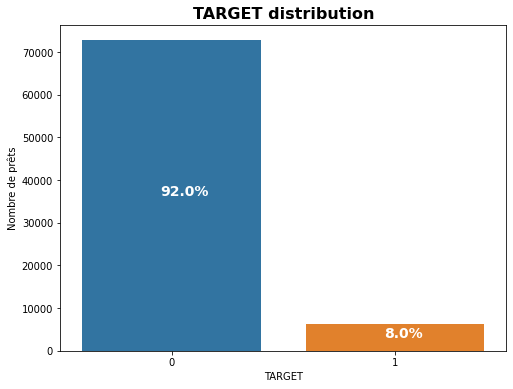

In [150]:
# Vérifions la distribution des classes après nettoyage
plot_target(my_data_w, 'TARGET', 'TARGET distribution', 'Nombre de prêts')

Elle reste très similaire.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### 1. Pondération

In [60]:
#https://www.justintodata.com/imbalanced-data-machine-learning-classification/#5-weighing-classes-differently
from sklearn.utils import compute_class_weight

weights = compute_class_weight('balanced', classes=my_data_w['TARGET'].unique(), y=my_data_w['TARGET'])
print("Voici les poids associés à chaque classe", weights)
print("Classe majoritaire TARGET = 0 :", weights[0])
print("Classe minoritaire TARGET = 1 :", weights[1])

Voici les poids associés à chaque classe [0.54327062 6.2775925 ]
Classe majoritaire TARGET = 0 : 0.5432706183087558
Classe minoritaire TARGET = 1 : 6.277592504367159


Au vu de la taille des données d'entrainement, nous allons sélectionner un échantillons de données (40%). Ceci permettra de tester les modèles avec des temps d'exécution acceptables.

In [61]:
# Echantillonnage des données
data_train_mean = training_data_sampling(my_data_w, 40)

original data shape: (79060, 555)
Données TARGET = 0: 72763  et données TARGET = 1: 6297
Echantillon TARGET = 0: 29105  et échantillon TARGET = 1: 2519
sampling data shape: (31624, 555)


In [62]:
# Préparation des données
X = data_train_mean.drop(columns=['TARGET'], axis=1)
y = data_train_mean['TARGET']

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,stratify=y)

#### 1. Baseline : Logistic Regression

In [63]:
pipe = Pipeline(steps = [('standardscaler', StandardScaler()),
                         ('LogisticRegression',  LogisticRegression(class_weight='balanced', max_iter=10000, random_state=888))])

C = [0.001, 0.01, 0.1, 1]

modele_parms = dict(#pca__n_components=n_components,
                    LogisticRegression__C=C)


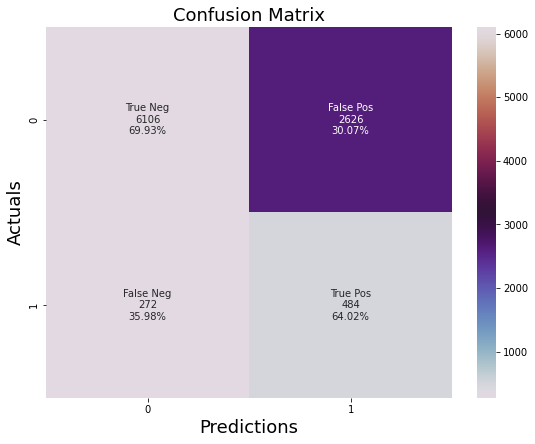

Meilleur modèle: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=10000, random_state=888))])
Wall time: 42.3 s


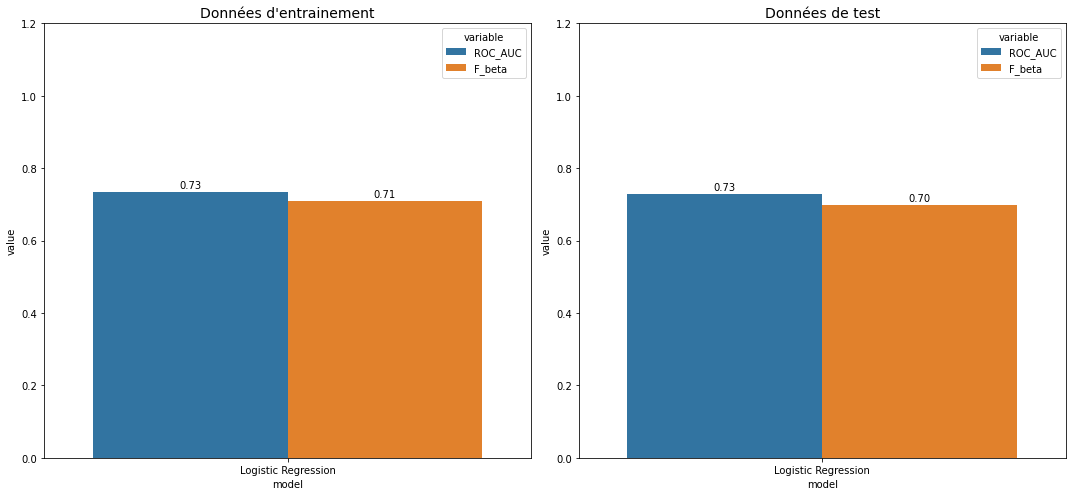

In [64]:
%%time
best_logistic_regression = class_imbalance_model_testing(pipe, modele_parms, 'Logistic Regression', X_train, y_train, X_test, y_test)

#### 2. Random Forest Classifier

In [65]:
pipe = Pipeline(steps = [('standardscaler', StandardScaler()),
                         ('RandomForest', RandomForestClassifier(class_weight='balanced', random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    RandomForest__n_estimators=n_estimators)

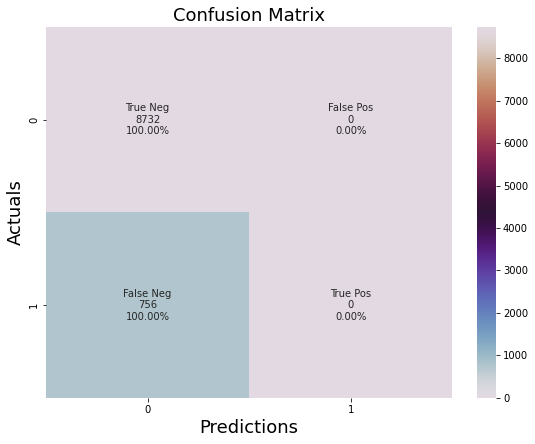

Meilleur modèle: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=888))])
Wall time: 5min 34s


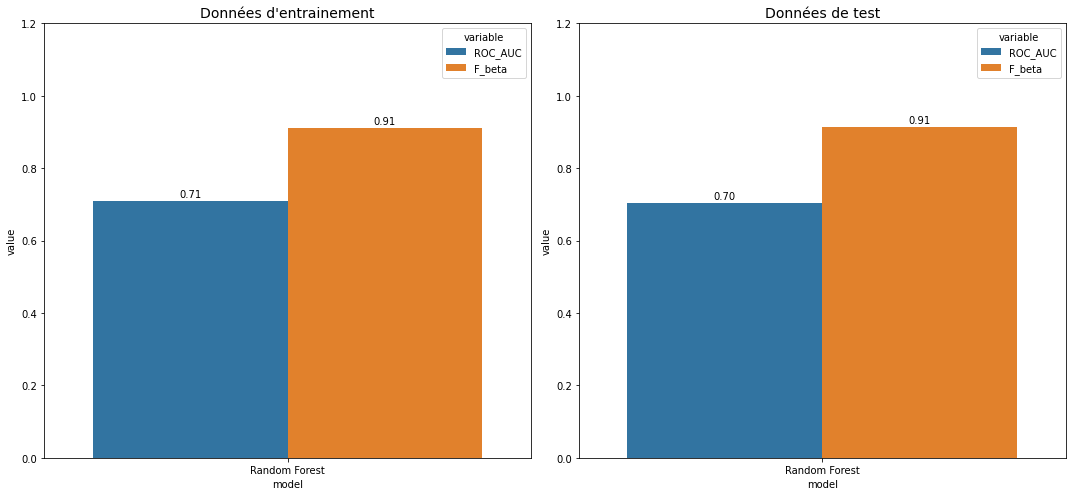

In [66]:
%%time
best_random_forest = class_imbalance_model_testing(pipe, modele_parms, 'Random Forest', X_train, y_train, X_test, y_test)

Ce modèle présente des caractéristiques moindre par rapport à la baseline, surtout sur les données test.
A noter que ce modèle ne réfuse aucun crédit (bof). Il est surtout bon dans la prédiction des acceptations de crédit.

#### 3. Gradient Boosting Classifier

In [67]:
pipe = Pipeline(steps = [('standardscaler', StandardScaler()),
                         ('GradientBoosting', GradientBoostingClassifier())])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    GradientBoosting__n_estimators=n_estimators)

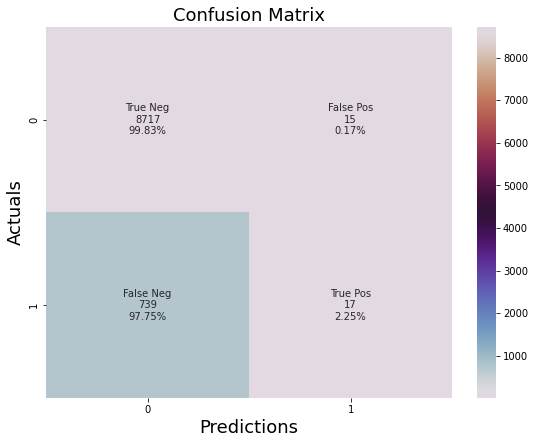

Meilleur modèle: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('GradientBoosting', GradientBoostingClassifier())])
Wall time: 33min 16s


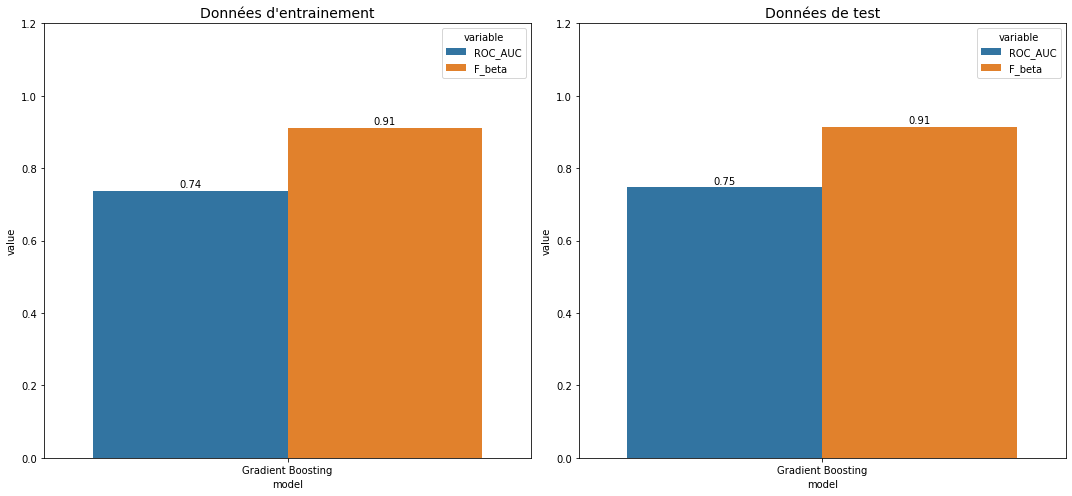

In [68]:
%%time
best_gradient_boosting = class_imbalance_model_testing(pipe, modele_parms, 'Gradient Boosting', X_train, y_train, X_test, y_test)

#### 4. Light Gradient Boosting Classifier

In [69]:
pipe = Pipeline(steps = [('standardscaler', StandardScaler()),
                         ('LGBMClassifier' , lgb.LGBMClassifier(class_weight='balanced', random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    LGBMClassifier__n_estimators=n_estimators)

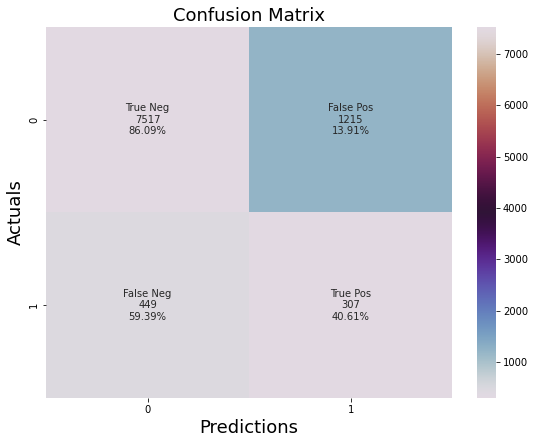

Meilleur modèle: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('LGBMClassifier',
                 LGBMClassifier(class_weight='balanced', random_state=888))])
Wall time: 36.3 s


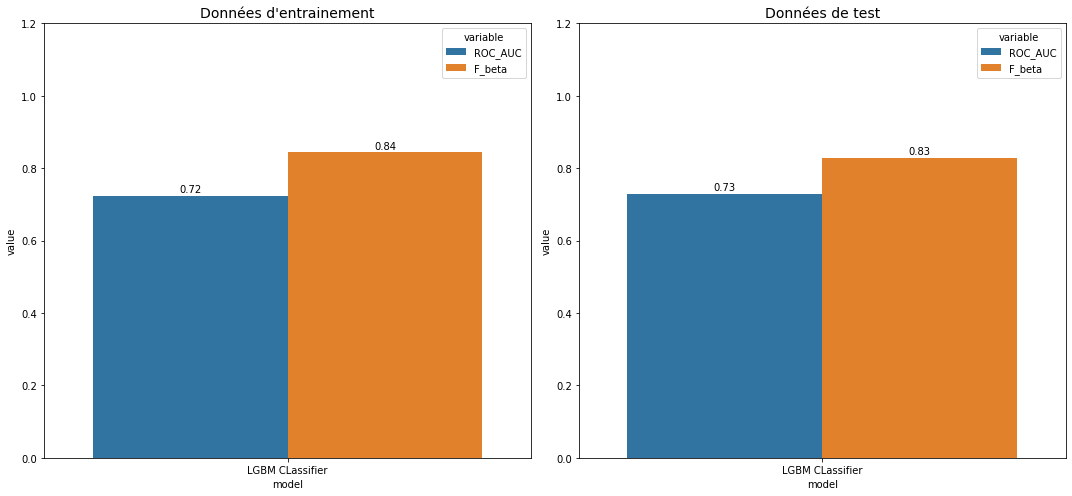

In [70]:
%%time
best_lgbm = class_imbalance_model_testing(pipe, modele_parms, 'LGBM CLassifier', X_train, y_train, X_test, y_test)

La regression logistique présente les meilleurs résultats. On observe une prédiction acceptable des deux classes. Le modèle LGBM s'en rapproche mais il n'égale pas.
Le modèle gradient boosting présente de très mauvaises performances (mauvaise prédiction classe 1 et temps d'exécution très élevé).

### 2. Undersampling ou <i>sous-échantillonnage</i>
Nous allons réduire la classe majoritaire via un échantillonnage aléatoire.

In [56]:
%%time
from imblearn.under_sampling import RandomUnderSampler

# Préparation des données
my_data_train = my_data_w.copy()
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,stratify=y)

Wall time: 573 ms


#### 1. Baseline : Logistic Regression

In [72]:
pipe = Pipeline(steps = [('Undersampling' , RandomUnderSampler(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('LogisticRegression',  LogisticRegression(max_iter=1000, random_state=888))])

C = [0.001, 0.01, 0.1, 1]

modele_parms = dict(#pca__n_components=n_components,
                    LogisticRegression__C=C)

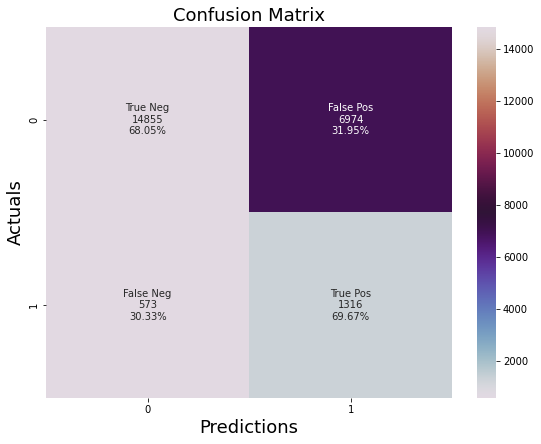

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=888))])
Wall time: 21.1 s


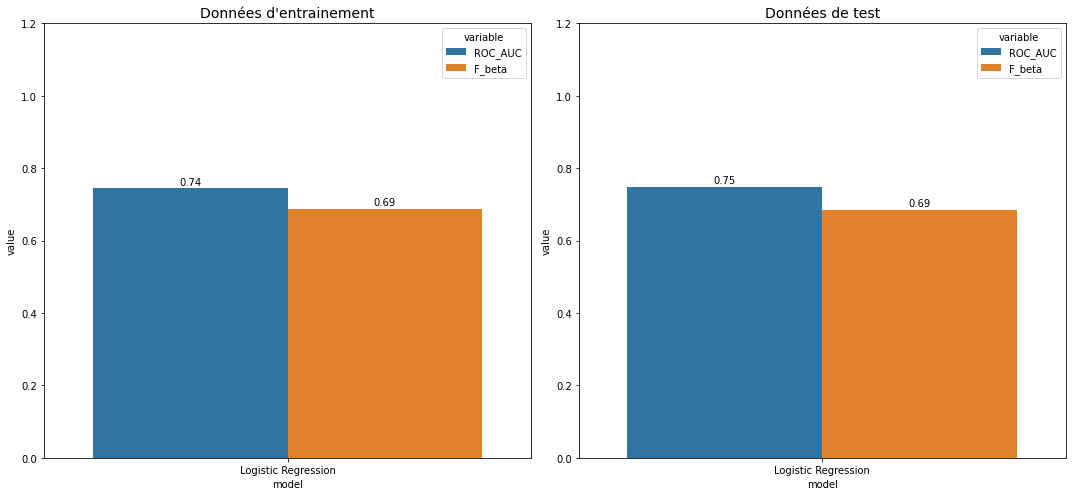

In [73]:
%%time
best_logistic_regression_under = class_imbalance_model_testing(pipe, modele_parms, 'Logistic Regression', X_train, y_train, X_test, y_test)

La baseline est plutôt performante. On observe une une très bonne prédiction des deux classes (68, 3 % pour classe 0 et 70.2 pour classe 1).

#### 2. Random Forest Classifier

In [74]:
pipe = Pipeline(steps = [('Undersampling' , RandomUnderSampler(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('RandomForest', RandomForestClassifier(random_state=888))])

n_estimators = [100, 200, 300]


modele_parms = dict(#pca__n_components=n_components,
                    RandomForest__n_estimators=n_estimators)

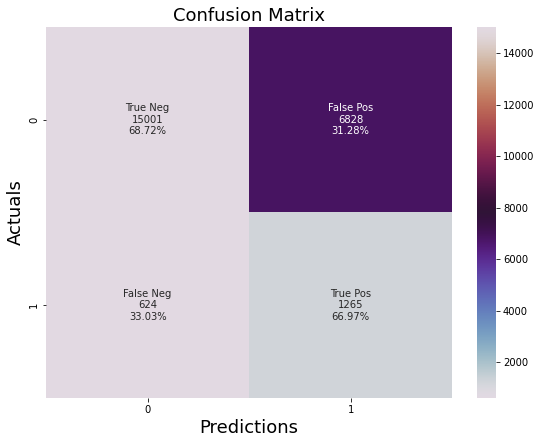

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(n_estimators=300, random_state=888))])
Wall time: 2min 44s


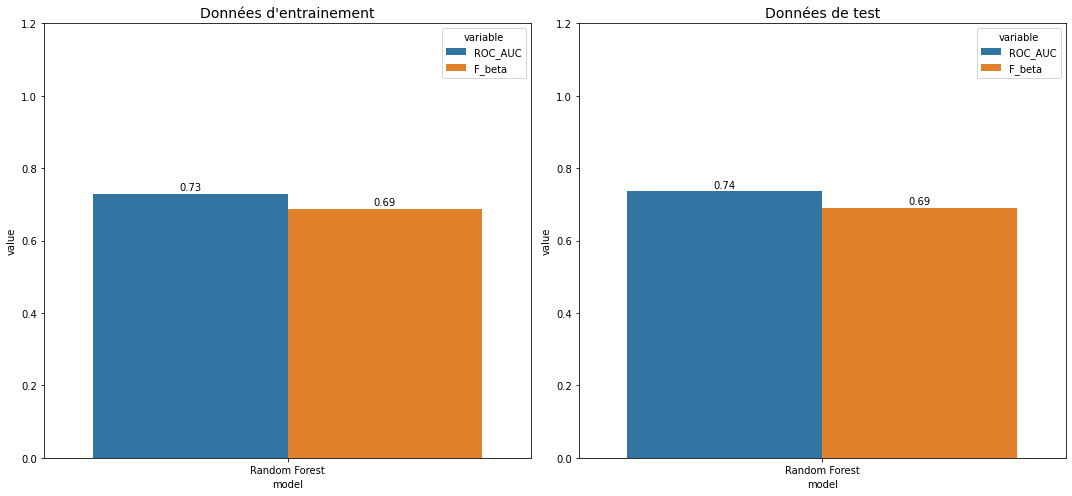

In [75]:
%%time
best_random_forest_under = class_imbalance_model_testing(pipe, modele_parms, 'Random Forest', X_train, y_train, X_test, y_test)

#### 3. Gradient Boosting Classifier

In [76]:
%%time
pipe = Pipeline(steps = [('Undersampling' , RandomUnderSampler(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('GradientBoosting', GradientBoostingClassifier())])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    GradientBoosting__n_estimators=n_estimators)

Wall time: 0 ns


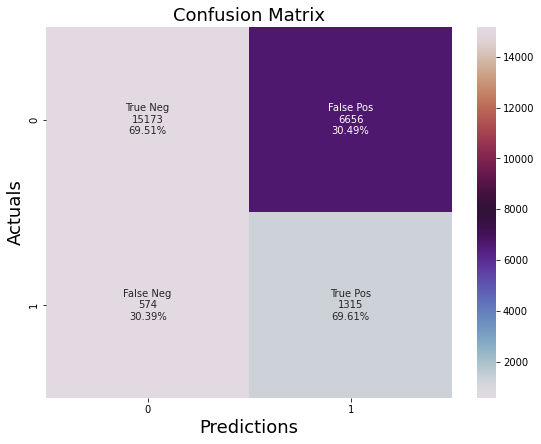

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('GradientBoosting', GradientBoostingClassifier())])
Wall time: 13min 4s


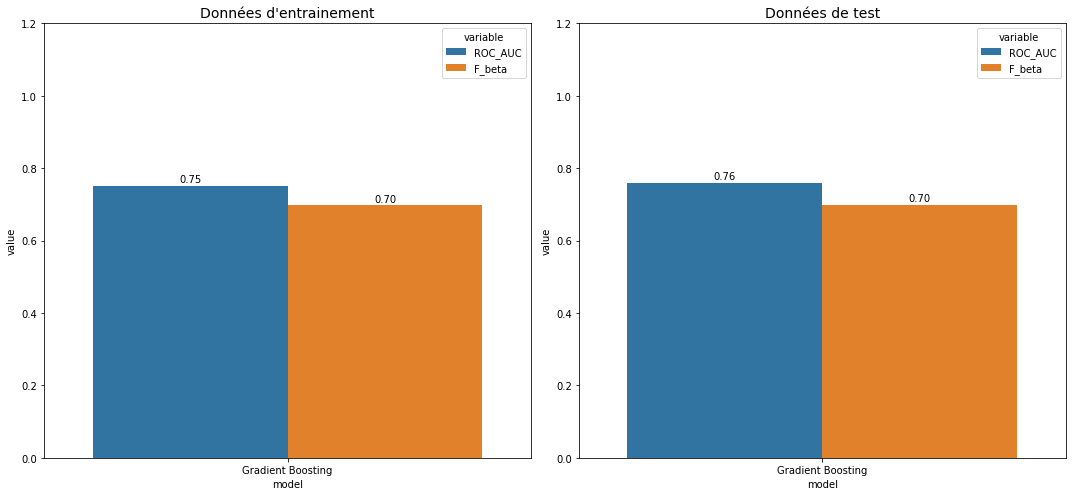

In [77]:
%%time
best_gradient_boosting = class_imbalance_model_testing(pipe, modele_parms, 'Gradient Boosting', X_train, y_train, X_test, y_test)

#### 4. Light Gradient Boosting Classifier 

In [57]:
pipe = Pipeline(steps = [('Undersampling' , RandomUnderSampler(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('LGBMClassifier' , lgb.LGBMClassifier(random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    LGBMClassifier__n_estimators=n_estimators)

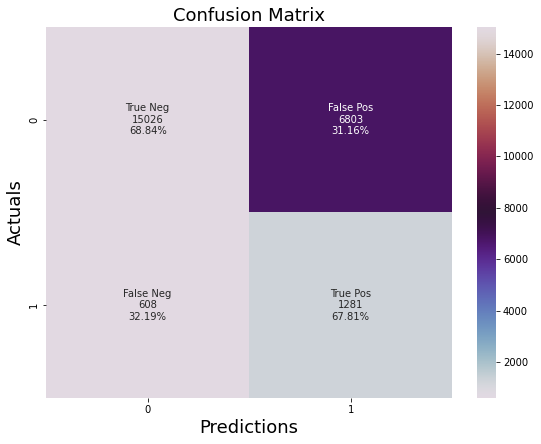

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier', LGBMClassifier(random_state=888))])
Wall time: 32 s


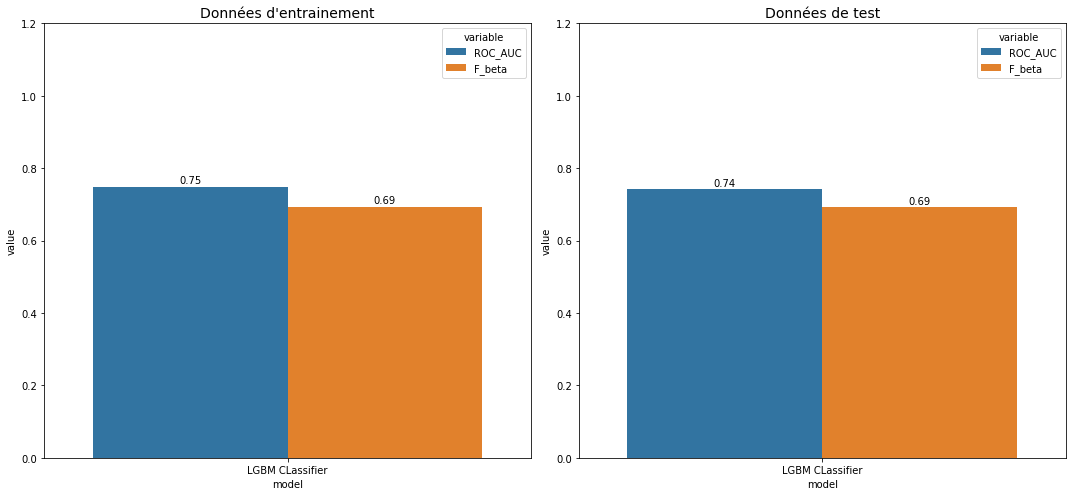

In [58]:
%%time
best_lgbm_under = class_imbalance_model_testing(pipe, modele_parms, 'LGBM CLassifier', X_train, y_train, X_test, y_test)

Encore une fois, le modèle Gradient Boosting est au dessus en terme de performance (+0.1 ROC_AUC). Seulement, le temps d'exécution est bien plus long que les autres modèles.
A noter que tous les modèles présentent de bonnes performances. La distinction se fait surtout sur le temps d'exécution...

### 3. Oversampling ou <i>sur-échantillonnage</i>
Nous allons augmenter la classe minoritaire.

Différentes méthodes de sur-échantillonnage existent. Nous allons en tester quelques unes.
Nous allons tester les méthodes SMOTE, Adasyn et quelques variations...

### 1. SMOTE

In [80]:
%%time
from imblearn.over_sampling import SMOTE
my_data_train = training_data_sampling(my_data_w, 40) # Il n'est pas nécessaire d'échantillonner

# Préparation des données
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

# SMOTE sur un échantillonnage de données
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y)

original data shape: (79060, 555)
Données TARGET = 0: 72763  et données TARGET = 1: 6297
Echantillon TARGET = 0: 29105  et échantillon TARGET = 1: 2519
sampling data shape: (31624, 555)
Wall time: 529 ms


#### 1. Baseline : Logistic regression

In [81]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('LogisticRegression',  LogisticRegression(max_iter=1000, random_state=888))])

C = [0.001, 0.01, 0.1, 1]

modele_parms = dict(#pca__n_components=n_components,
                    LogisticRegression__C=C)

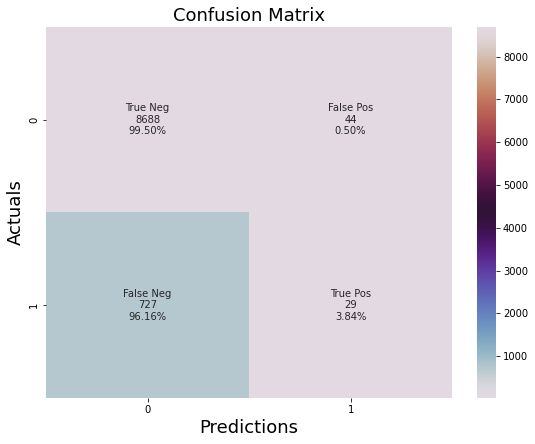

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=888))])
Wall time: 1min 13s


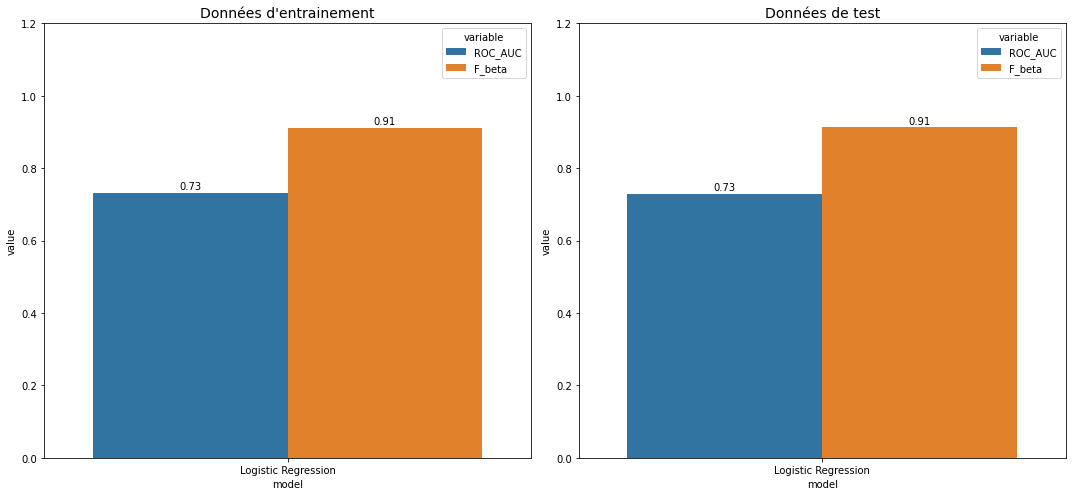

In [82]:
%%time
best_logistic_regression_smote = class_imbalance_model_testing(pipe, modele_parms, 'Logistic Regression', X_train, y_train, X_test, y_test)

#### 2. Random Forest Classifier

In [83]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('RandomForest', RandomForestClassifier(random_state=888))])

n_estimators = [100, 200, 300]


modele_parms = dict(#pca__n_components=n_components,
                    RandomForest__n_estimators=n_estimators)

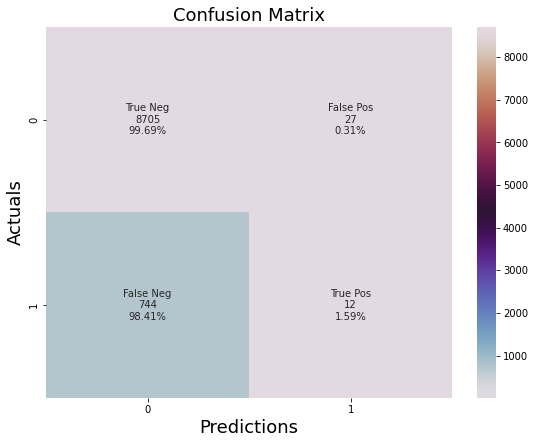

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(n_estimators=300, random_state=888))])
Wall time: 16min 29s


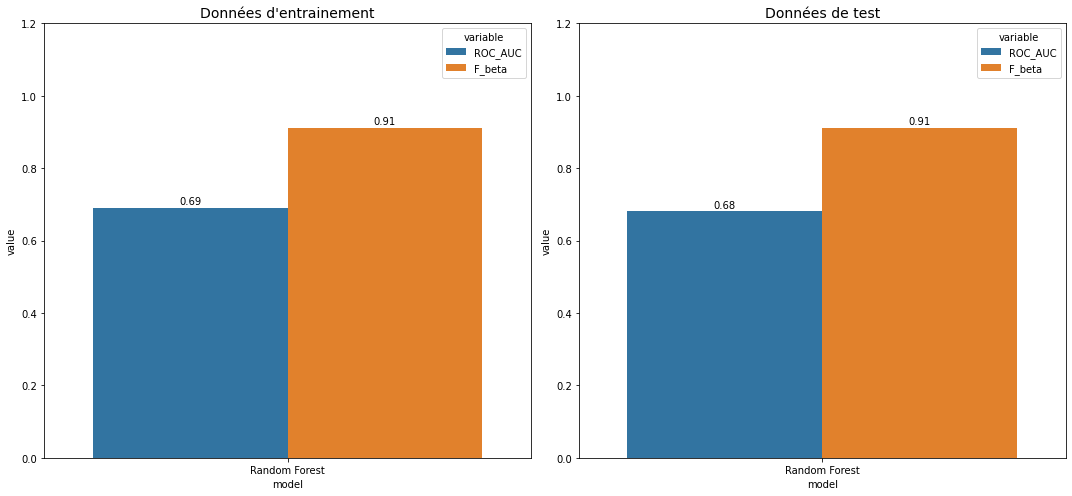

In [84]:
%%time
best_random_forest_smote = class_imbalance_model_testing(pipe, modele_parms, 'Random Forest', X_train, y_train, X_test, y_test)

#### 3. Gradient Boosting Classifier

#### 4. Light Gradient Boosting Classifier

In [85]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(random_state=888)),
                         ('standardscaler', StandardScaler()),
                         ('LGBMClassifier' , lgb.LGBMClassifier(random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    LGBMClassifier__n_estimators=n_estimators)

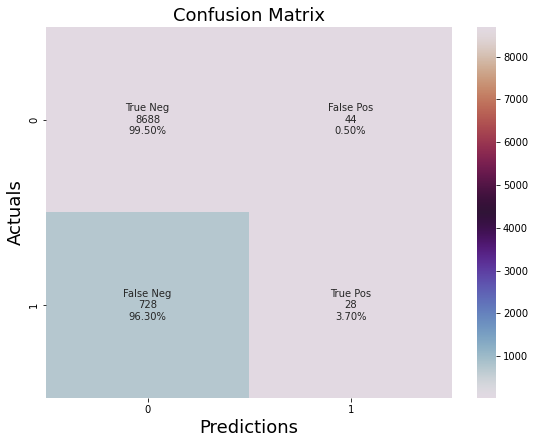

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier', LGBMClassifier(random_state=888))])
Wall time: 1min 8s


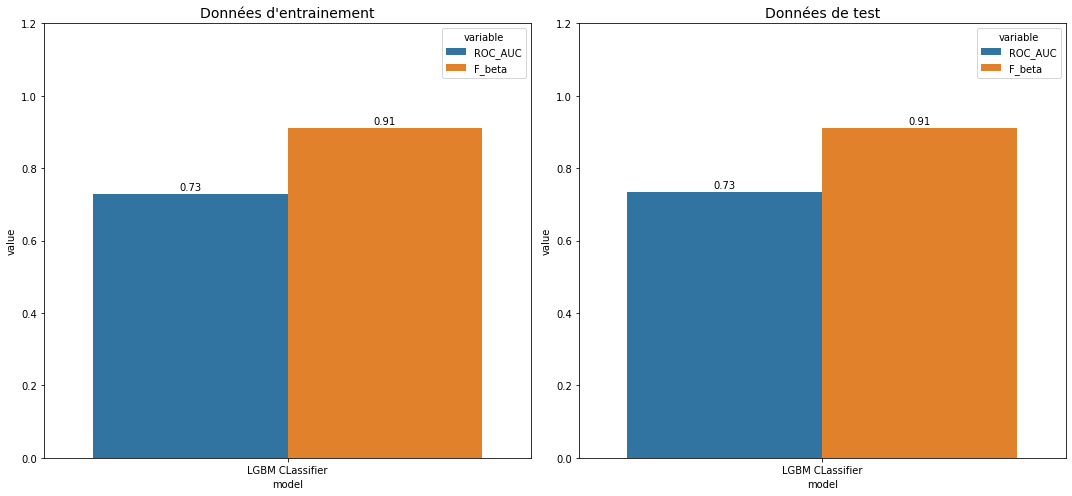

In [86]:
%%time
best_lgbm_smote = class_imbalance_model_testing(pipe, modele_parms, 'LGBM CLassifier', X_train, y_train, X_test, y_test)

A noter que la méthode d'équilibrage SMOTE est celle qui présente les performances les plus mauvaises.
Les cas 'False Pos' et 'True Pos' sont très peu représentés. Seule la classe 0 est bien représentée et bien prédite.

Nous allons vérifier si ces pietres performances sont en lien avec le fait que le jeu de test soit déséquilibré.

#### 5. Test sur un jeu de données équilibré
Vérifions si les performances sont les mêmes lorsque le jeu de test est équilibré.

In [87]:
print('Donnée test shape :', X_test.shape)
rus = RandomUnderSampler(random_state=888)
X_resampled, y_resampled = rus.fit_resample(X_test, y_test)

my_data_test = pd.concat([X_resampled, y_resampled], axis = 1)

print("TARGET = 1 samples:", len(my_data_test[my_data_test.TARGET == 1])) 
print("TARGET = 0 samples:", len(my_data_test[my_data_test.TARGET == 0]))

X = my_data_test.drop(columns='TARGET', axis=1)
y = my_data_test['TARGET']

Donnée test shape : (9488, 554)
TARGET = 1 samples: 756
TARGET = 0 samples: 756


##### Test du modèle

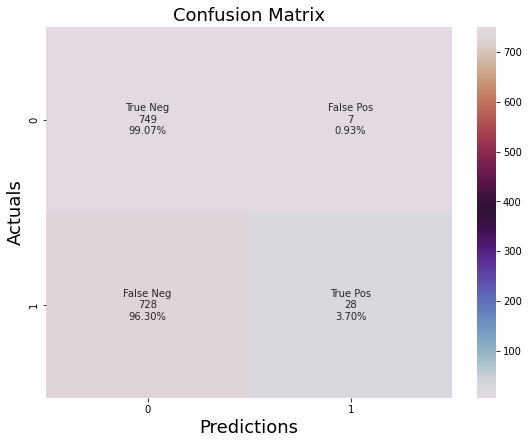

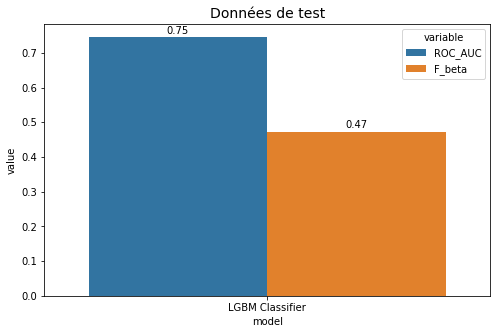

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
    
scoring = { 'roc_auc': 'roc_auc',
           'fbeta': make_scorer(fbeta_score, average='weighted', beta=np.sqrt(10))       
           }
    
test_df = pd.DataFrame(columns=['model','ROC_AUC','F_beta'])
best_model = best_lgbm_smote

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_train, y_train, cv=kfold, scoring=scoring)
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:,1]
cf_matrix_roc_auc(best_model, y, y_pred)
        
# Affichage métriques des données de test          
test_df=test_df.append({'model' : 'LGBM Classifier' ,  
                        'ROC_AUC'  : roc_auc_score(y, y_pred_proba, average='weighted'),
                        'F_beta'   : fbeta_score(y, y_pred, average='weighted', beta=3)} , 
                         ignore_index=True)
stack_test=test_df.melt(id_vars=['model'])    

# Visualisation    
fig, axes= plt.subplots(figsize=(8,5))
bar = sns.barplot(x='model', y= 'value', hue='variable', data=stack_test)
plt.title("Données de test", fontsize=14)
    
for p in bar.patches:
    height = p.get_height()
    bar.text(p.get_x()+p.get_width()/2,
    height + 0.01,
    "%.2f" % p.get_height(),
    ha="center") 

Tester sur un jeu de données équilibré n'améliore pas les performances.

### 4. SMOTE suivi d'undersampling

In [89]:
%%time
my_data_train = training_data_sampling(my_data_w, 50)
# Préparation des données
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,stratify=y)

original data shape: (79060, 555)
Données TARGET = 0: 72763  et données TARGET = 1: 6297
Echantillon TARGET = 0: 36382  et échantillon TARGET = 1: 3148
sampling data shape: (39530, 555)
Wall time: 564 ms


#### 1. Baseline : Logistic Regression

In [90]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(sampling_strategy=0.8)), 
                         ('Under' , RandomUnderSampler()),
                         ('standardscaler', StandardScaler()),
                         ('LogisticRegression',  LogisticRegression(max_iter=1000, random_state=888))])

C = [0.001, 0.01, 0.1, 1]

modele_parms = dict(#pca__n_components=n_components,
                    LogisticRegression__C=C)

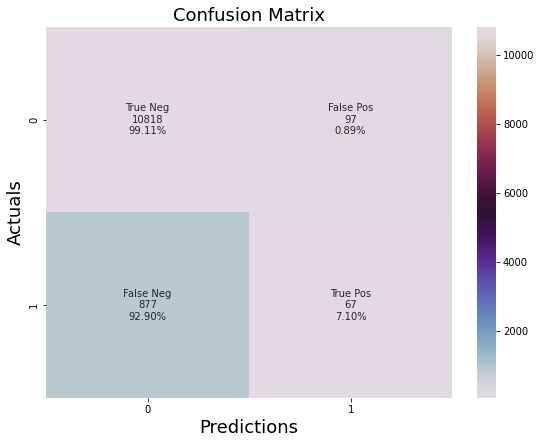

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(sampling_strategy=0.8)),
                ('Under', RandomUnderSampler()),
                ('standardscaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=888))])
Wall time: 1min 26s


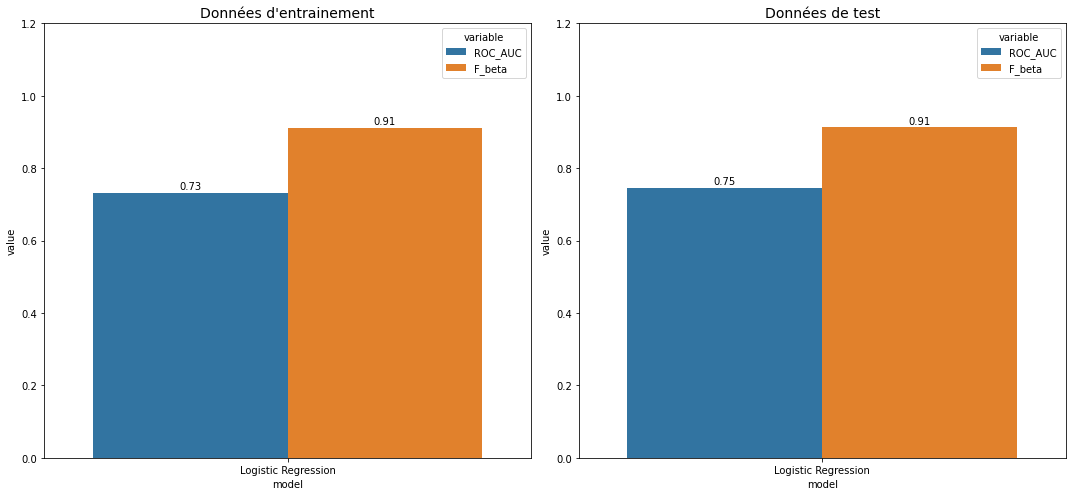

In [91]:
%%time
best_logistic_regression_smote_under = class_imbalance_model_testing(pipe, modele_parms, 'Logistic Regression', X_train, y_train, X_test, y_test)

#### 2. Random Forest Classifier

In [92]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(sampling_strategy=0.1)), 
                         ('Under' , RandomUnderSampler(sampling_strategy=0.25)),
                         ('standardscaler', StandardScaler()),
                         ('RandomForest', RandomForestClassifier(random_state=888))])

n_estimators = [100, 200, 300]


modele_parms = dict(#pca__n_components=n_components,
                    RandomForest__n_estimators=n_estimators)

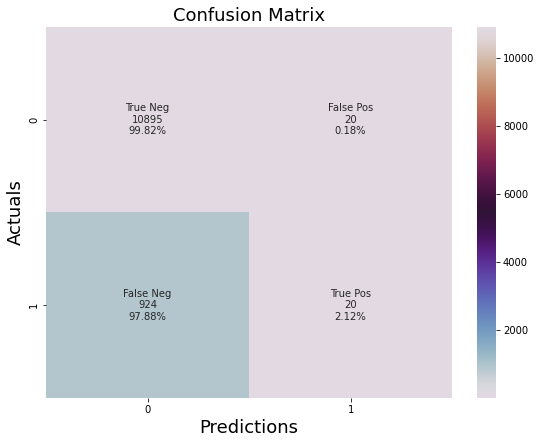

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(sampling_strategy=0.1)),
                ('Under', RandomUnderSampler(sampling_strategy=0.25)),
                ('standardscaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(n_estimators=300, random_state=888))])
Wall time: 4min 3s


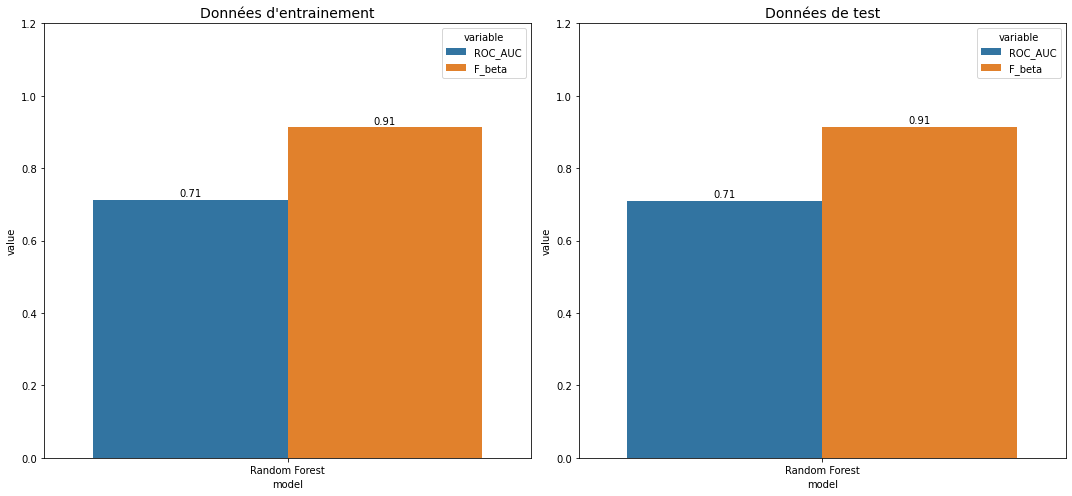

In [93]:
%%time
best_random_forest_smote_under = class_imbalance_model_testing(pipe, modele_parms, 'Random Forest', X_train, y_train, X_test, y_test)

#### 3. Gradient Boosting Classifier

#### 4. Light Gradient Boosting Classifier

In [94]:
pipe = Pipeline(steps = [('SMOTE' , SMOTE(sampling_strategy=0.1)), 
                         ('Under' , RandomUnderSampler(sampling_strategy=0.25)),
                         ('standardscaler', StandardScaler()),
                         ('LGBMClassifier' , lgb.LGBMClassifier(random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    LGBMClassifier__n_estimators=n_estimators)

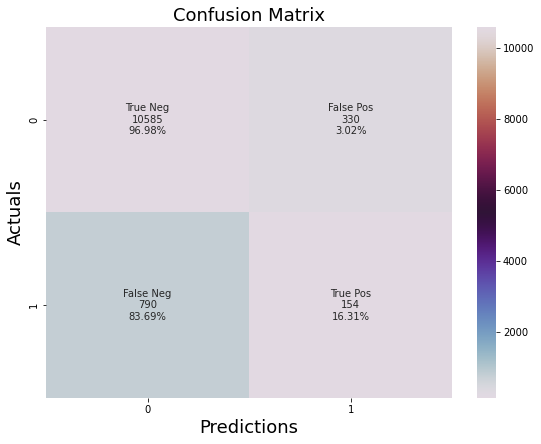

Meilleur modèle: Pipeline(steps=[('SMOTE', SMOTE(sampling_strategy=0.1)),
                ('Under', RandomUnderSampler(sampling_strategy=0.25)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier', LGBMClassifier(random_state=888))])
Wall time: 35.7 s


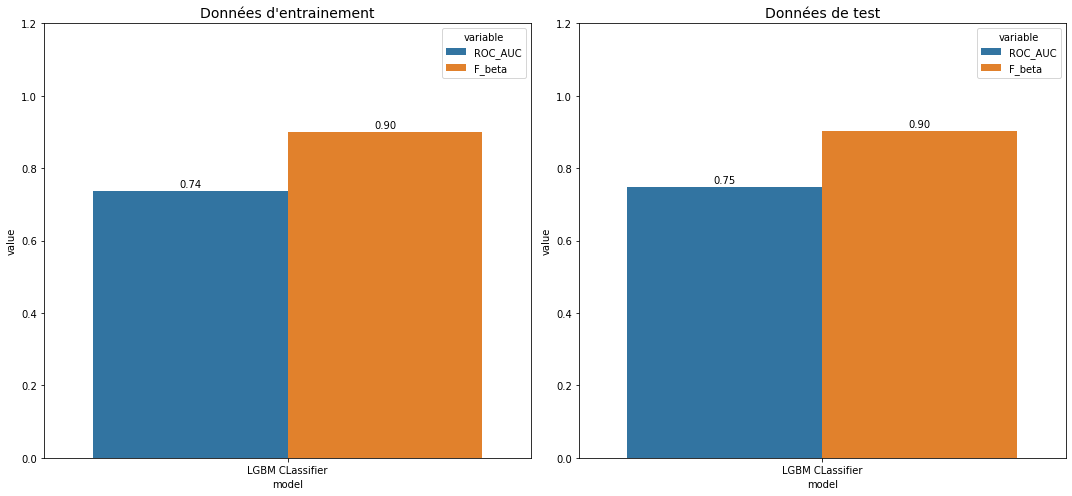

In [95]:
%%time
best_lgbm_smote_under = class_imbalance_model_testing(pipe, modele_parms, 'LGBM CLassifier', X_train, y_train, X_test, y_test)

SMOTE suivi d'undersampling semble apporter de meilleures performances que SMOTE seule. Cependant, cela ne vaut pas les performances du sous-échantillonnage.

### 5. ADASYN

In [96]:
%%time
from imblearn.over_sampling import ADASYN

my_data_train = training_data_sampling(my_data_w, 50)

# Préparation des données
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,stratify=y)

original data shape: (79060, 555)
Données TARGET = 0: 72763  et données TARGET = 1: 6297
Echantillon TARGET = 0: 36382  et échantillon TARGET = 1: 3148
sampling data shape: (39530, 555)
Wall time: 541 ms


#### 1. Baseline : Logistic Regression

In [97]:
pipe = Pipeline(steps = [('adasyn', ADASYN()),
                         ('standardscaler', StandardScaler()),
                         ('LogisticRegression',  LogisticRegression(max_iter=1000, random_state=888))])

C = [0.001, 0.01, 0.1, 1]

modele_parms = dict(#pca__n_components=n_components,
                    LogisticRegression__C=C)

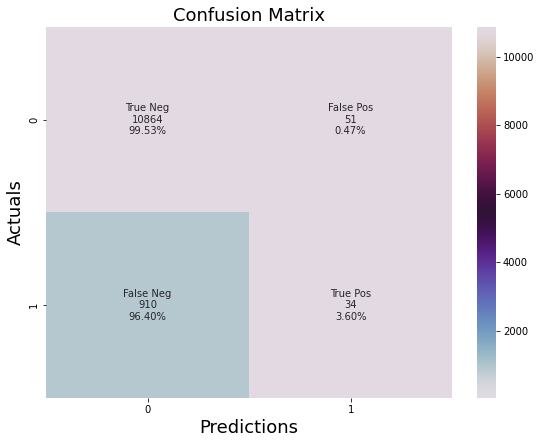

Meilleur modèle: Pipeline(steps=[('adasyn', ADASYN()), ('standardscaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=1, max_iter=1000, random_state=888))])
Wall time: 2min 6s


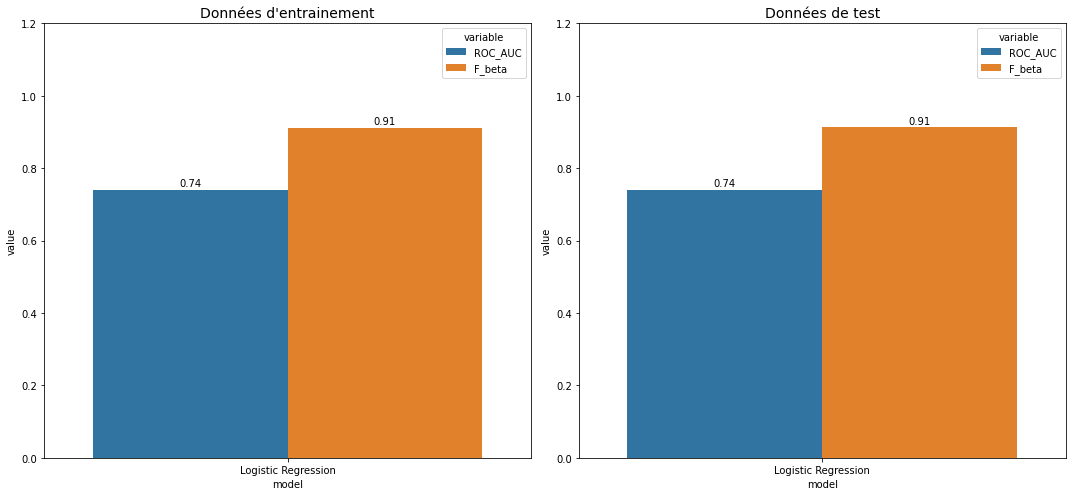

In [98]:
%%time
best_logistic_regression_adasyn = class_imbalance_model_testing(pipe, modele_parms, 'Logistic Regression', X_train, y_train, X_test, y_test)

#### 2. Random Forest Classifier

In [99]:
pipe = Pipeline(steps = [('adasyn', ADASYN()),
                         ('standardscaler', StandardScaler()),
                         ('RandomForest', RandomForestClassifier(random_state=888))])

n_estimators = [100, 200, 300]


modele_parms = dict(#pca__n_components=n_components,
                    RandomForest__n_estimators=n_estimators)

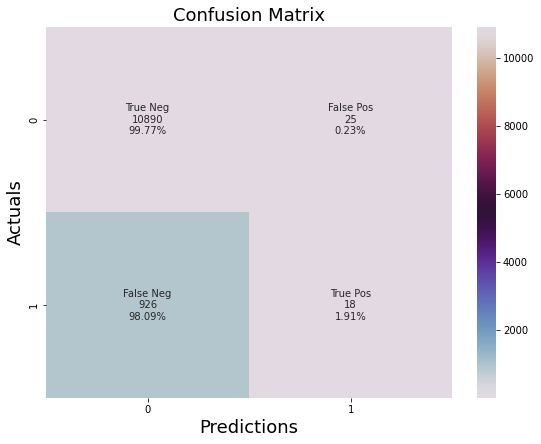

Meilleur modèle: Pipeline(steps=[('adasyn', ADASYN()), ('standardscaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(n_estimators=200, random_state=888))])
Wall time: 1h 59min 37s


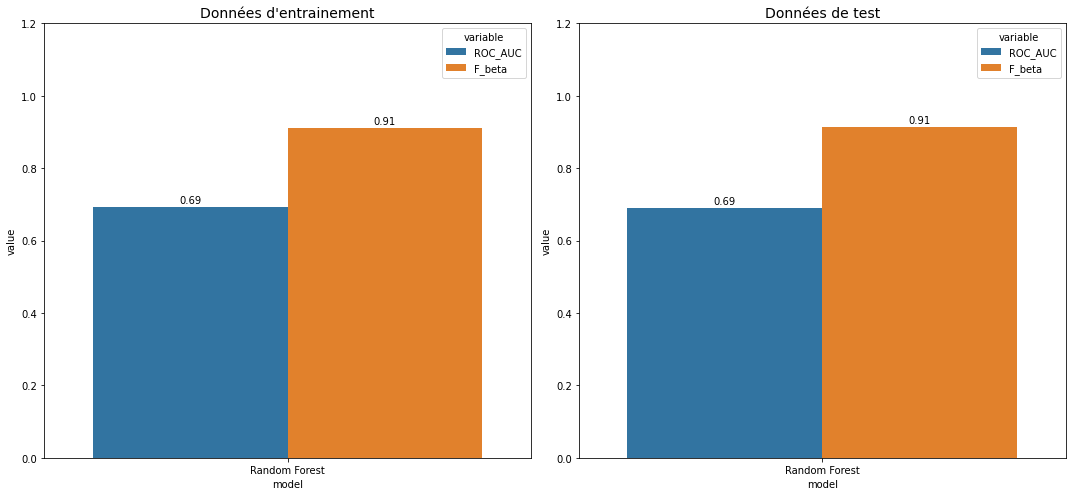

In [100]:
%%time
best_random_forest_adasyn = class_imbalance_model_testing(pipe, modele_parms, 'Random Forest', X_train, y_train, X_test, y_test)

#### 3. Gradient Boosting Classifier

#### 4. Light Gradient Boosting Classifier

In [101]:
pipe = Pipeline(steps = [('adasyn', ADASYN()),
                         ('standardscaler', StandardScaler()),
                         ('LGBMClassifier' , lgb.LGBMClassifier(random_state=888))])

n_estimators = [100, 200, 300]

modele_parms = dict(#pca__n_components=n_components,
                    LGBMClassifier__n_estimators=n_estimators)

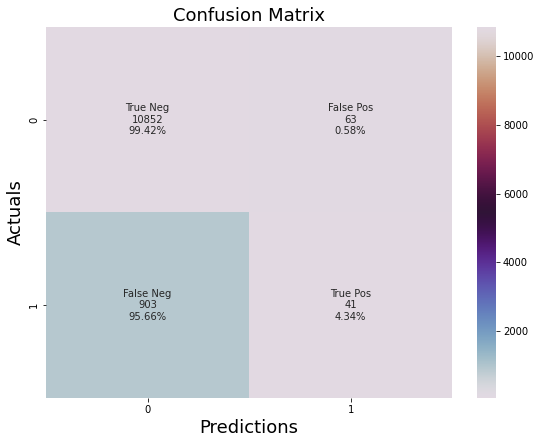

Meilleur modèle: Pipeline(steps=[('adasyn', ADASYN()), ('standardscaler', StandardScaler()),
                ('LGBMClassifier', LGBMClassifier(random_state=888))])
Wall time: 1min 44s


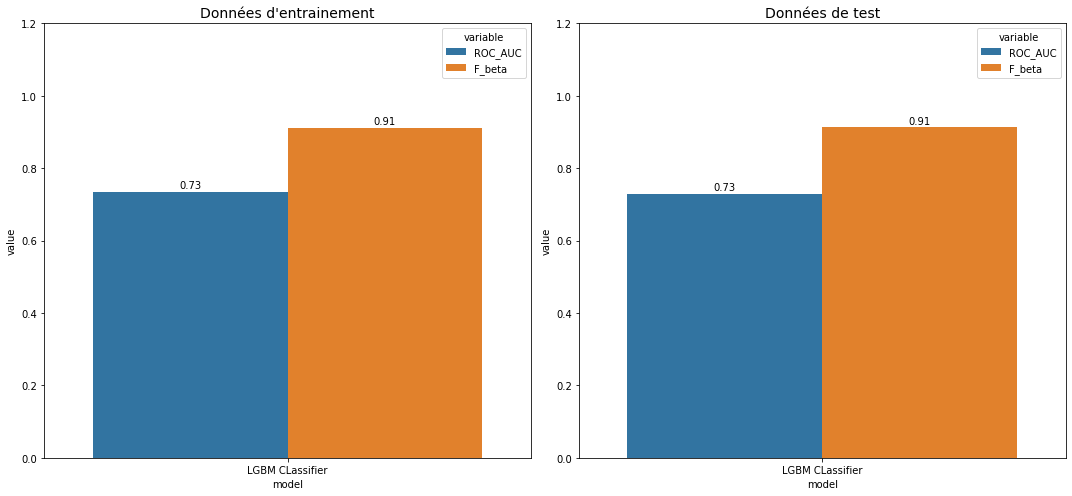

In [102]:
%%time
best_lgbm_adasyn = class_imbalance_model_testing(pipe, modele_parms, 'LGBM CLassifier', X_train, y_train, X_test, y_test)

Il est intéressant de remarquer que pour notre jeu de donnée, et quelque soit la méthode de sur-échantillonnage utilisée, nous n'observons pas de bonnes performances.

Les métriques (ROC AUC, F1, FBETA), quelque soit le modèle ou la transformation sont assez similaires.
La différence entre les transformations se fait au niveau de la matrice de confusion.
L'intégralité des transformations permet une bonne prédiction de la classe 0. <b>Seulement, seul le sous-échantillonnage ou <i>undersampling</i> permet une prédiction acceptable de la classe minoritaire 1</b>.

A noter que la méthode qui combine le sur et le sous échantillonnage semble être plus performante que le sur-échantillonnage seul mais ce n'est pas suffisant.

### 3. Choix du modèle final et optimisation des hyperparamètres.

Notre choix va se porter sur le modèle LGBMClassifier parce qu'il présente des performances aussi bonnes que la baseline (métriques et temps confondus). Qui plus est, il semble présenter davantage de possibilités d'optimisation (en comparaison de la baseline).

En ce qui concerne l'optimisation, nous allons tester deux méthodes.
- Gridsearchcv
- hyperopt (semble apporter de meilleures performances en terme de temps)

##### Optimisation des hyperparamètres avec Gridsearchcv

In [103]:
%%time
# Préparation des données
my_data_train = my_data_w.copy()
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

Wall time: 364 ms


In [104]:
modele_parms = { 'LGBMClassifier__max_depth': range(3,10,2),  
                 'LGBMClassifier__num_leaves': [8,32,128,512], 
                 'LGBMClassifier__learning_rate': [0.1,0.03,0.07,0.001],
                 'LGBMClassifier__n_estimators': [100,200,300,400,500]  }

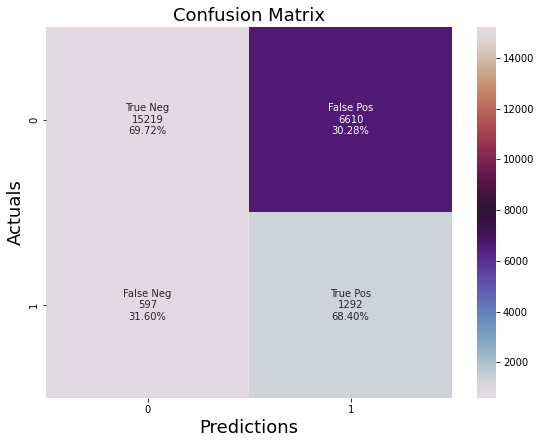

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=7,
                                n_estimators=500, num_leaves=8,
                                random_state=888))])
Wall time: 49min 12s


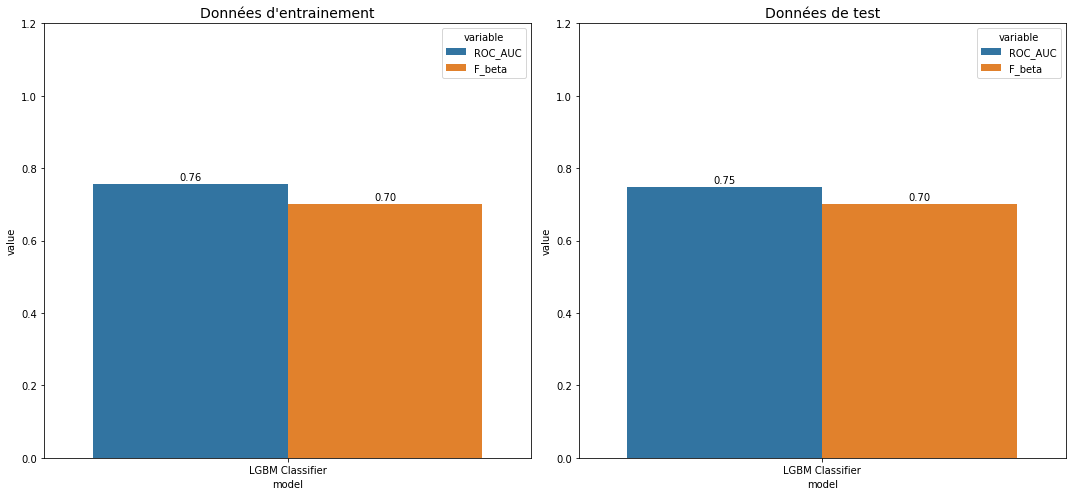

In [105]:
%%time
best_lgbm_new = class_imbalance_model_testing(best_lgbm_under, modele_parms, 'LGBM Classifier', X_train, y_train, X_test, y_test)

On reste sur ROC AUC = <b>0.75</b>.

#### Optimisation des hyperparamètres avec hyperopt

In [59]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.05),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 35, 5),
    }

In [60]:
# Fonction fn hyperopt
def hyperparameter_tuning_roc_auc(params):
    
    '''Hyperopt va minimiser l'erreur générée par cette fonction.
       Métrique : ROC_AUC '''
    
    params = {
        'LGBMClassifier__n_estimators': int(params['n_estimators']),
        'LGBMClassifier__learning_rate': params['learning_rate'],
        'LGBMClassifier__max_depth': int(params['max_depth']),
        'LGBMClassifier__num_leaves': int(params['num_leaves'])}
    
    model = best_lgbm_under.set_params(**params)
    cv = StratifiedKFold(5)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, error_score='raise').mean()

    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


<b>Recherche du meilleur ROC_AUC</b>

In [61]:
%%time
# Initialize trials object
trials = Trials()

best = fmin(fn=hyperparameter_tuning_roc_auc, space=space, max_evals=30, algo=tpe.suggest)
print("Best: {}".format(best))

100%|██████████| 30/30 [03:31<00:00,  7.04s/trial, best loss: 0.24371517606789306]
Best: {'learning_rate': 0.042064837480570695, 'max_depth': 4.0, 'n_estimators': 300.0, 'num_leaves': 30.0}
Wall time: 3min 31s


In [62]:
final_params = {'LGBMClassifier__n_estimators' : [int(best['n_estimators'])],
                'LGBMClassifier__learning_rate' : [best['learning_rate']],
                'LGBMClassifier__max_depth': [int(best['max_depth'])],
                'LGBMClassifier__num_leaves': [int(best['num_leaves'])]}


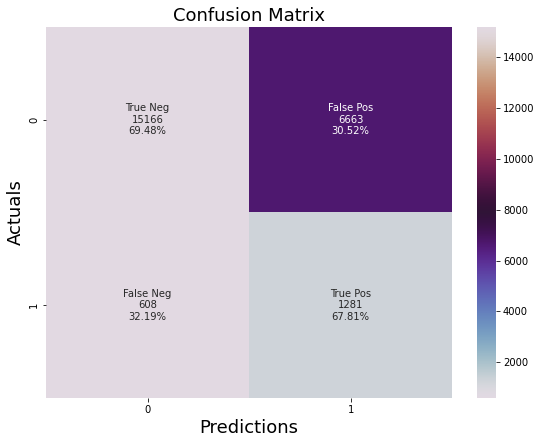

Meilleur modèle: Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=888)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier',
                 LGBMClassifier(learning_rate=0.042064837480570695, max_depth=4,
                                n_estimators=300, num_leaves=30,
                                random_state=888))])
Wall time: 8.59 s


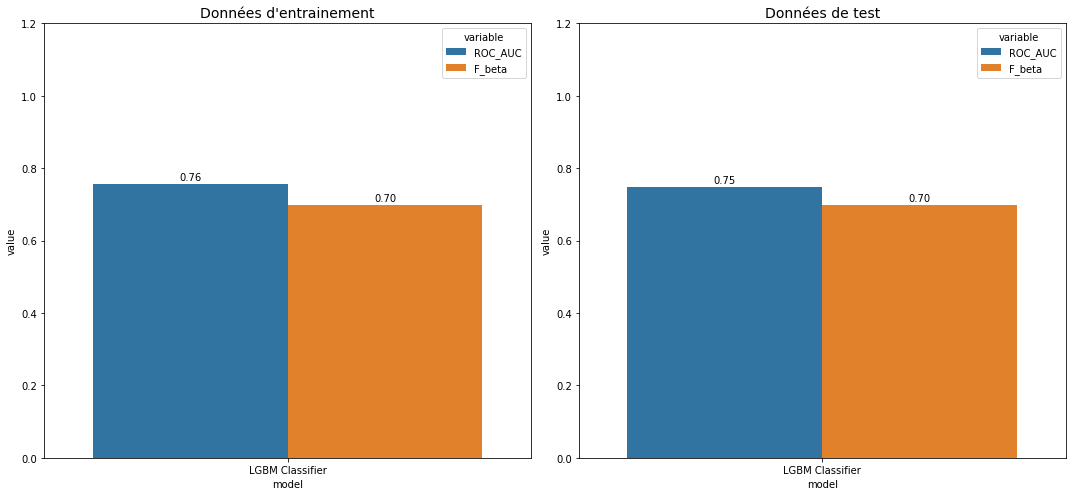

In [63]:
%%time
best_lgbm_final_1 = class_imbalance_model_testing(best_lgbm_under, final_params, 'LGBM Classifier', X_train, y_train, X_test, y_test)

hyperopt est bien plus performant dans la recherche de paramètres optimaux que gridsearchcv.

### 4. Calcul de la fonction coût - Optimisation du modèle d'un point de vue métier

Afin de donner vie à cette fonction "coût", il faut prendre en compte la problématique métier.
Nous devons prendre en compte qu'un faux positif n'a pas le même coût qu'un faux négatif.
Contextualisons :
- Un faux positif est un client solvable à qui nous allons refuser une demande de crédit. Ceci entraine un manque à gagner pour l'organisme de crédit.
- Un faux négatif est un client non solvable à qui on accorde une demande de crédit. Cette fois cela entraine des pertes pour l'organisme de crédit.

Ainsi, nous comprenons que le second cas est bien plus impactant pour l'entreprise que le premier. Nous devons minimiser les <b>faux négatifs</b>. Ceci est possible avec la fonction $F_\beta score$.
Ce dernière permet d'attribuer plus de poids à la minimisation des faux négatifs à travers la pondération du paramètre beta.

Ci-dessous les formules de la fonction $F_\beta score$

- $F_\beta score = (1 + \beta^2)\frac{precision*recall}{(\beta^2precision) + recall}$

- $F_\beta score = \frac{TP}{TP + \frac{1}{1 + \beta^2}(\beta^2FN + FP)}$


Résumé :
   - Si $\beta > 1$, on accorde plus d'importance au recall (autrement dit aux faux négatifs) => On minimise la précision
   - Si $\beta < 1$, on accorde plus d'importance à la précision (autrement dit aux faux positifs) => On minimise le recall
   - Si $\beta = 1$, la précision et le recall ont la même importance. C'est le - Si $F_{1}score$.

Ensuite, il sera intéressant de définir une nouvelle matrice de confusion avec le seuil qui donnera la meilleure répartition des classes (la matrice de confusion change en fonction du seuil défini).

Ici, <b>$\beta = 10^{1/2}$</b>

Compute the F-beta score.

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

Le paramètre beta détermine le poids du recall dans le score final. beta < 1 donne plus de poids à la précision, tandis que beta > 1 favorise le recall (beta = 0 ne considère que la précision, beta = +inf que le recall).

Precision = TP / (FP + TP). La capacité de prédire les vrais positifs sur tous les positifs prédits. La proportion d'observations correctements prédites positives parmi toutes les observations prédites positives.
Recall = TP / (FN + TP). La capacité de prédire les positifs sur l'ensemble des positifs initiaux. La proportion d'observations correctements prédites positives parmi toutes les observations positives.

Notre but ici, est de maximiser le recall et donc lui donner plus de poids. 

La valeur de béta doit être fixée en collaboration avec les équipes métiers.

Nous allons étudier plusieurs possibilités. Et nous allons les comparer à la précision et au recall actuels.
https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/#What_is_Precision_Score

Wall time: 50.1 s


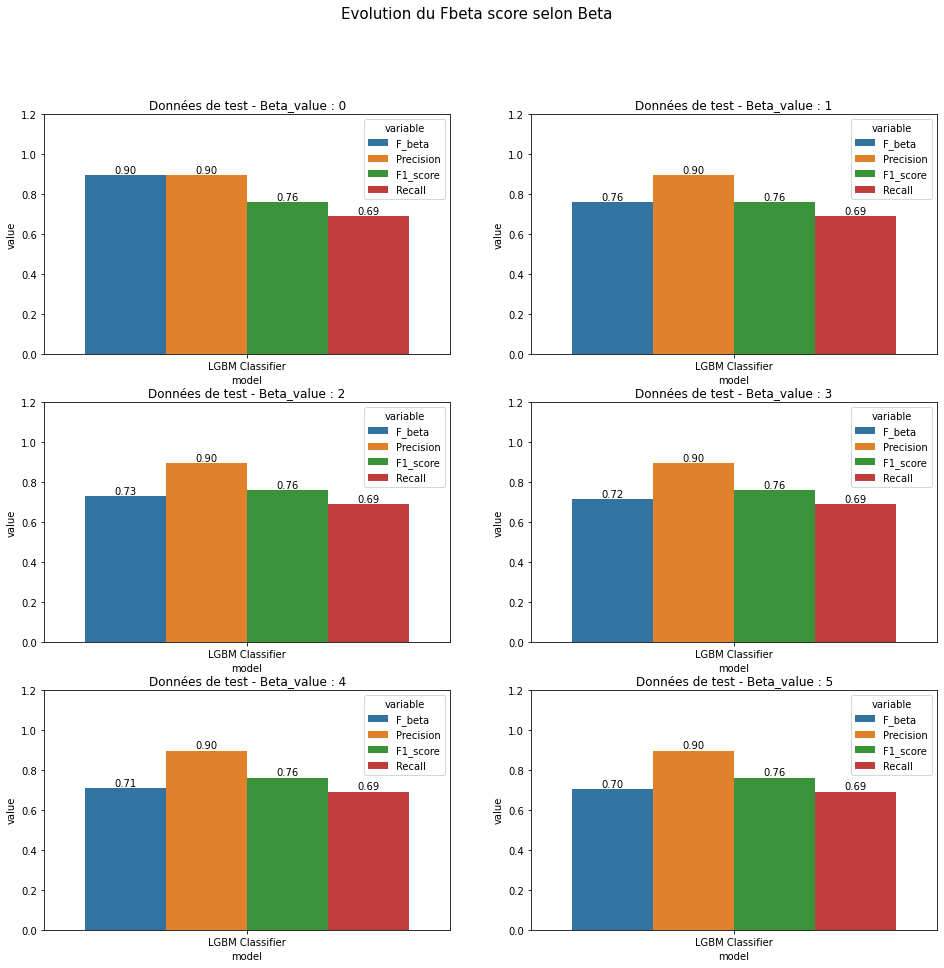

In [119]:
%%time
from imblearn.under_sampling import RandomUnderSampler
pipe = Pipeline(steps=[('Undersampling', RandomUnderSampler(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('LGBMClassifier', LGBMClassifier())])

# Préparation des données
my_data_train = my_data_w.copy()
X = my_data_train.drop(columns=['TARGET'], axis=1)
y = my_data_train['TARGET']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,stratify=y)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


beta_values = [0, 1, 2, 3, 4, 5]

params = {      'LGBMClassifier__n_estimators' : int(best['n_estimators']),
                'LGBMClassifier__learning_rate' : best['learning_rate'],
                'LGBMClassifier__max_depth': int(best['max_depth']),
                'LGBMClassifier__num_leaves': int(best['num_leaves'])      }

fig = plt.figure(figsize=(16,15))   
plt.suptitle("Evolution du Fbeta score selon Beta", fontsize=15)

for index,i in enumerate(beta_values):
    
    ax = fig.add_subplot(3,2, (index +1))
    ax.set_title("Données de test - Beta_value : "+ str(i))
    
    scoring = {'f1_weighted': 'f1_weighted',
           'roc_auc': 'roc_auc',
           'fbeta': make_scorer(fbeta_score, average='weighted', beta=i)       
           }
    
    test_df = pd.DataFrame(columns=['model','F_beta','Precision', 'F1_score', 'Recall'])

    actual_pipe = pipe.set_params(**params)    
    cv_results = cross_validate(actual_pipe, X_train, y_train, cv=kfold, scoring=scoring)
    pipe_result = actual_pipe.fit(X_train, y_train)     
    y_pred = pipe_result.predict(X_test)
    y_pred_proba = pipe_result.predict_proba(X_test)[:,1]

    # Affichage métriques des données de test
    test_df=test_df.append({'model' : 'LGBM Classifier' , 
                        'F1_score' : f1_score(y_test, y_pred, average='weighted'), 
                        'F_beta'   : fbeta_score(y_test, y_pred, beta=np.sqrt(i), average='weighted', pos_label = 1),
                        'Precision'   : precision_score(y_test, y_pred, average='weighted', pos_label = 1),
                        'Recall'   : recall_score(y_test, y_pred, average='weighted', pos_label = 1)  } , # pos_label = 1 par défaut
                         ignore_index=True)
    stack_test=test_df.melt(id_vars=['model'])    
    # Visualisation
    
    bar = sns.barplot(x='model', y= 'value', hue='variable',data=stack_test, ax=ax)
    ax.yaxis.set_ticks(np.arange(0,1.4,0.2))
    
    for p in bar.patches:
        height = p.get_height()
        bar.text(p.get_x()+p.get_width()/2,
        height + 0.01,
        "%.2f" % p.get_height(),
        ha="center") 



Nous notons bien qu'à partir de beta = 2, Fbeta est inférieure au F1 score et se rapproche davantage du recall. Plus la valeur de beta augmente plus F beta se rapproche du recall.
Une solution serait de prendre Beta=3,parce que c'est la valeur à partir de laquelle nous sommes bien plus proche du recall que du F1 score (valeur à laquelle recall et précision ont le même poids).

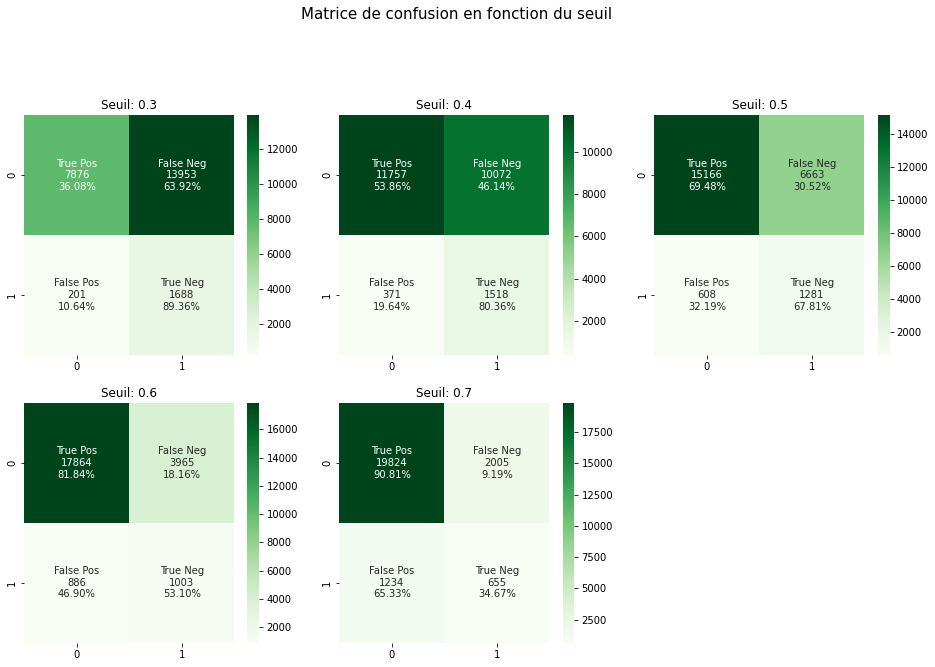

In [152]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(16,15))   
plt.suptitle("Matrice de confusion en fonction du seuil", fontsize=15)

for index, thresh in enumerate(thresholds):
    pred_values = np.array(list(map(lambda x : 1 if x > thresh else 0, pipe_result.predict_proba(X_test)[:,1])))
    ax = fig.add_subplot(3,3, (index +1))
    ax.set_title('Seuil: ' + str(thresh))
    cf_matrix = confusion_matrix(y_test, pred_values)
    group_names = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix[0].flatten()/np.sum(cf_matrix[0])]
    group_percentages.extend(["{0:.2%}".format(value) for value in cf_matrix[1].flatten()/np.sum(cf_matrix[1])])
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Greens', ax=ax)#

    

Les seuils à privilégier sont 0.4 et 0.5.

## 3. Features importance

### Global feature importance

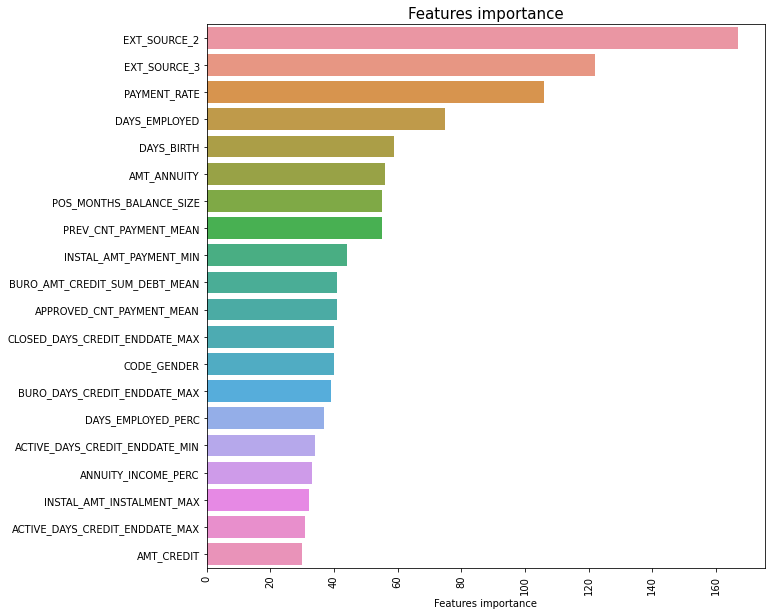

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

fig = plt.figure(figsize=(10,10))

params = {      'LGBMClassifier__n_estimators' : int(best['n_estimators']),
                'LGBMClassifier__learning_rate' : best['learning_rate'],
                'LGBMClassifier__max_depth': int(best['max_depth']),
                'LGBMClassifier__num_leaves': int(best['num_leaves'])      }

actual_pipe = best_lgbm_under.set_params(**params)    
pipe_result = actual_pipe.fit(X_train, y_train)
y_pred = pipe_result.predict(X_test)

indices = np.argsort(actual_pipe.steps[-1][1].feature_importances_)[::-1]
    
features = []
for i in range(20):
    features.append(X_train.columns[indices[i]])

sns.barplot(y=features, x=actual_pipe.steps[-1][1].feature_importances_[indices[range(20)]])
plt.xlabel('Features importance')
plt.xticks(rotation=90)
plt.title('Features importance', fontsize=15)

plt.show()

In [134]:
# Module shap values

import shap  
# Create object that can calculate shap values
tree_explainer = shap.TreeExplainer(actual_pipe.steps[-1][1])
shap_values = tree_explainer.shap_values(X_test)
#shap_v = explainer(X_test)

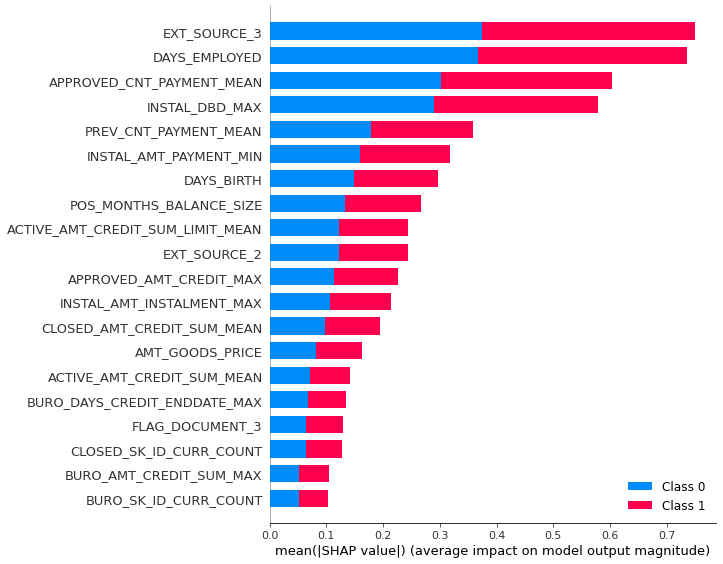

In [135]:
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

Elles ne sont pas forcément classées de la même manière mais nous retrouvons des variables similaires dans les features importance native du modèle et dans shap.
EXT_SOURCE_3, DAYS_EMPLOYED, DAYS_BIRTH...

### Local feature importance

In [112]:
# Choix d'un client unique
y_pred_proba = actual_pipe.steps[-1][1].predict_proba(X_test) # Probabilité de l'entièreté du jeu de donnée
y_pred = actual_pipe.steps[-1][1].predict(X_test)

# Création d'un dataframe avec les données y_test et y_pred.
df_y_target = y_test.to_frame()
df_y_target['y_pred'] = y_pred
df_y_target.head(3)

,TARGET,y_pred
SK_ID_CURR,,
263118,0,0
420915,0,0
266940,0,0


#### Local features importance d'un client en défaut de paiement

In [113]:
# Sélection d'un client prédit en défaut de paiement.
df_y_target.loc[df_y_target.y_pred == 1].head(5)

,TARGET,y_pred
SK_ID_CURR,,
426314,0,1
342059,0,1
258665,0,1
246689,1,1
215425,0,1


In [118]:
data_a_predire = X_test[X_test.index == 426314]
pred = actual_pipe.steps[-1][1].predict_proba(data_a_predire)
print(pred)
shap_values = tree_explainer.shap_values(data_a_predire)

[[0.22108108 0.77891892]]


Ce client a presque 78 % de chance d'être en défaut de paiement.

In [120]:
shap.force_plot(tree_explainer.expected_value[1], shap_values[1], data_a_predire)

In [121]:
shap.force_plot(tree_explainer.expected_value[0], shap_values[0], data_a_predire)

#### Local features importance d'un client sans défaut de paiement

In [122]:
# Choix d'un client unique (sans défaut de paiement.)
# Sélection d'un client prédit en défaut de paiement.
df_y_target.loc[df_y_target.y_pred == 0].head(5)

,TARGET,y_pred
SK_ID_CURR,,
263118,0,0
420915,0,0
266940,0,0
213678,0,0
429108,0,0


In [136]:
data_a_predire = X_test[X_test.index == 263118]
pred = actual_pipe.steps[-1][1].predict_proba(data_a_predire)
print(pred)
shap_values = tree_explainer.shap_values(data_a_predire)

[[0.71290359 0.28709641]]


In [137]:
shap.force_plot(tree_explainer.expected_value[1], shap_values[1], data_a_predire)

In [138]:
shap.force_plot(tree_explainer.expected_value[0], shap_values[0], data_a_predire)

#### Extraction du modèle sélectionné.

In [158]:
import pickle
with open('LGBM_model_final.pkl', 'wb') as f1:
    pickle.dump(actual_pipe.steps[-1][1], f1)

#### Transfer du fichier d'entrainement tronqué (pour affichage dashboard) 
GitHub n'autorise pas de fichier au-délà de 25 mb

In [231]:
my_data_transfer = training_data_sampling(my_data_w, 40)
my_data_transfer.shape

original data shape: (79060, 556)
Données TARGET = 0: 72763  et données TARGET = 1: 6297
Echantillon TARGET = 0: 29105  et échantillon TARGET = 1: 2519
sampling data shape: (31624, 556)


(31624, 556)

In [242]:
my_data_transfer.reset_index().to_csv("training_data.csv", index=False)

#### Modification du fichier initial (application_train) à des fins de traitement par le dashboard
Les variables inutiles sont supprimées afin de respecter les limites de GitHub

In [248]:
general_info_app = application_train[['SK_ID_CURR','DAYS_BIRTH', 'CODE_GENDER',
                                      'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'OCCUPATION_TYPE', 
                                      'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                      'AMT_ANNUITY','AMT_GOODS_PRICE', 'TARGET']]

In [250]:
general_info_app.to_csv("general_info_app.csv", index=False)